#### Imports

In [1]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from sklearn.preprocessing import LabelEncoder

import os

In [ ]:
# pip install librosa

#### Reading the dataframe with file ids and class labels

In [2]:
data = pd.read_csv('/Users/gildardo/Downloads/train/train.csv')

In [3]:
data

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
...,...,...
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling


#### Reading a random audio file to listen to it

In [4]:
i = random.choice(data.ID)
i=132
ipd.Audio('/Users/gildardo/Downloads/train/Train/'+str(i)+'.wav')

#### Research showed the most important features we can extract from an audio file using librosa which is a great python library for audio 

![librosa_features](img/librosa_features.jpg)

#### Function to extract the most common audio features from librosa for each sound file. We also added the class label at the end

In [5]:
# Although this function was modified and many parameteres were explored with, most of it 
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('/Users/gildardo/Downloads/train/Train')+'/'+str(files.ID)+'.wav')

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.Class

    return mfccs, chroma, mel, contrast, tonnetz, label

In [6]:
# Applying the function to the train data by accessing each row of the dataframe
features_labels = data.apply(extract_features, axis=1)

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=785
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=393
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=675
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=953
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222:

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=955
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=827
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=414
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=800
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=400
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=566
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=646
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=323
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=708
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=354
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=712
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=356
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=178
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=722
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=736
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1007
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=504
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=252
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=595
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=623
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=213
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=714
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=814
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=407
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=204
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=824
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=104
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=683
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=342
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=556
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=606
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=76
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=38
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1023
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=685
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input s

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=945
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=473
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=555
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=934
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=954
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=969
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=485
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1010
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=642
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=321
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=915
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=458
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=601
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=301
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=151
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=755
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=378
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=189
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=659
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=789
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=937
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=106
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=656
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=164
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=254
  warnings.warn(
/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input 

#### We get 4 arrays of numbers, one for each feature

In [7]:
features_labels

0       ([-82.12359, 139.50592, -42.430866, 24.82786, ...
1       ([-15.744005, 124.11996, -29.42888, 39.44719, ...
2       ([-123.393654, 15.181946, -50.09333, 7.1418724...
3       ([-213.27881, 89.323586, -55.256187, 12.632097...
4       ([-237.92648, 135.90245, 39.26844, 21.240236, ...
                              ...                        
5430    ([-214.6584, 178.9413, -1.2636192, 63.96227, 6...
5431    ([-395.34592, 105.813354, -0.19629021, -7.0979...
5432    ([-320.81738, 58.300556, -6.8695035, 15.693743...
5433    ([-277.03183, 141.14565, -36.329124, 39.45575,...
5434    ([-290.99673, 233.35156, -4.6723504, 4.6523294...
Length: 5435, dtype: object

In [8]:
# It takes a long time to extract those features from the files so we will save the results 
# in a dataframe to be able to access them if needed
features_df = pd.DataFrame(features_labels)
features_df.to_csv('features_df.csv', index=False)

In [9]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_labels)):
    features.append(np.concatenate((features_labels[i][0], features_labels[i][1], 
                features_labels[i][2], features_labels[i][3],
                features_labels[i][4]), axis=0))

In [10]:
len(features)

5435

In [11]:
# Similarly, we create a list where we will store all the labels

labels = []
for i in range(0, len(features_labels)):
    labels.append(features_labels[i][5])

In [12]:
len(labels)

5435

In [13]:
# to let me know when it's done
os.system('say -v Juan ya acabé');

#### Checking if we have balanced classes

In [14]:
np.unique(labels, return_counts=True)

(array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
        'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
        'street_music'], dtype='<U16'),
 array([600, 306, 600, 600, 600, 624, 230, 668, 607, 600]))

#### Hot encoding y and pre processing X and y

In [15]:
# Setting our X as a numpy array to feed into the neural network
X = np.array(features)

In [16]:
# Setting our y
y = np.array(labels)

In [17]:
y

array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U16')

In [18]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [19]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
# Checking our shapes
X.shape

(5435, 193)

In [21]:
# Checking our shapes
y.shape

(5435, 10)

In [22]:
# Choosing the first 3435 files to be our train data
# Choosing the next 1000 files to be our validation data
# Choosing the next 1000 files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series

X_train = X[:3435]
y_train = y[:3435]

X_val = X[3435:4435]
y_val = y[3435:4435]

X_test = X[4435:]
y_test = y[4435:]

We need to make sure that our splits still contain the proportion of our classes, either balanced or unbalanced (analogous to stratify)

In [23]:
data[:3435]['Class'].value_counts(normalize=True)

jackhammer          0.125182
street_music        0.114410
siren               0.113537
air_conditioner     0.112955
engine_idling       0.112082
drilling            0.109170
dog_bark            0.108006
children_playing    0.106841
car_horn            0.053566
gun_shot            0.044250
Name: Class, dtype: float64

In [24]:
data[3435:4435]['Class'].value_counts(normalize=True)

children_playing    0.131
jackhammer          0.126
engine_idling       0.118
air_conditioner     0.113
dog_bark            0.109
siren               0.104
drilling            0.103
street_music        0.101
car_horn            0.054
gun_shot            0.041
Name: Class, dtype: float64

In [25]:
data[4435:]['Class'].value_counts(normalize=True)

drilling            0.122
engine_idling       0.121
dog_bark            0.120
siren               0.113
jackhammer          0.112
street_music        0.106
children_playing    0.102
air_conditioner     0.099
car_horn            0.068
gun_shot            0.037
Name: Class, dtype: float64

Checking the shapes, making sure everything is in order

In [26]:
X_train.shape

(3435, 193)

In [27]:
y_train.shape

(3435, 10)

In [28]:
X_val.shape

(1000, 193)

In [29]:
y_val.shape

(1000, 10)

We need to scale all our X splits to have better results

In [30]:
# Scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [31]:
from datetime import datetime
startTime = datetime.now()

#### Grid searching over the neural network to find best parameters

In [32]:
def model_func(layer_one_neurons=128, layer_one_dropout=.5, layer_two_neurons=512, 
               layer_two_dropout=.5, layer_three_neurons=128, layer_three_dropout=.5):
    
    model = Sequential()
    
    model.add(Dense(layer_one_neurons,
                    input_shape=(193,),
                          activation='relu'))
    
    model.add(Dropout(layer_one_dropout))
    
    model.add(Dense(layer_two_neurons,
                    activation='relu'))
    
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(layer_three_neurons,
                    activation='relu'))

    model.add(Dropout(layer_three_dropout))

    model.add(Dense(10,
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model


nn = KerasRegressor(model_func, batch_size=512, verbose=2)

params = {
    'epochs': [100],
    'layer_one_neurons': [193],
    'layer_two_neurons': [64, 128],
    'layer_three_neurons': [128, 256],
    'layer_one_dropout': [.25,.5],
    'layer_two_dropout': [.5,.75],
    'layer_three_dropout': [.5,.75]
}
gs = GridSearchCV(nn, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Epoch 1/100
5/5 - 1s - loss: 2.5980 - accuracy: 0.0904
Epoch 2/100
5/5 - 0s - loss: 2.3755 - accuracy: 0.1323
Epoch 3/100
5/5 - 0s - loss: 2.2796 - accuracy: 0.1686
Epoch 4/100
5/5 - 0s - loss: 2.1788 - accuracy: 0.2245
Epoch 5/100
5/5 - 0s - loss: 2.1363 - accuracy: 0.2332
Epoch 6/100
5/5 - 0s - loss: 2.0509 - accuracy: 0.2808
Epoch 7/100
5/5 - 0s - loss: 1.9780 - accuracy: 0.3031
Epoch 8/100
5/5 - 0s - loss: 1.9196 - accuracy: 0.3166
Epoch 9/100
5/5 - 0s - loss: 1.9107 - accuracy: 0.3231
Epoch 10/100
5/5 - 0s - loss: 1.7971 - accuracy: 0.3686
Epoch 11/100
5/5 - 0s - loss: 1.7508 - accuracy: 0.3681
Epoch 12/100
5/5 - 0s - loss: 1.7005 - accuracy: 0.3956
Epoch 13/100
5/5 - 0s - loss: 1.6502 - accuracy: 0.4240
Epoch 14/100
5/5 - 0s - loss: 1.5655 - accuracy: 0.4550
Epoch 15/100
5/5 - 0s - loss: 1.5310 - accuracy: 0.4594
Epoch 16/100
5/5 - 0s - loss: 1.4758 - accuracy: 0.4830
Epoch 17/100
5/5 - 0s - loss: 1.3926 - accuracy: 0.5227
Epoch 18/100
5/5 - 0s - loss: 1.3715 - accuracy: 0.5306
E

Epoch 47/100
5/5 - 0s - loss: 0.6808 - accuracy: 0.7843
Epoch 48/100
5/5 - 0s - loss: 0.6646 - accuracy: 0.7838
Epoch 49/100
5/5 - 0s - loss: 0.6774 - accuracy: 0.7777
Epoch 50/100
5/5 - 0s - loss: 0.6441 - accuracy: 0.7856
Epoch 51/100
5/5 - 0s - loss: 0.6329 - accuracy: 0.7900
Epoch 52/100
5/5 - 0s - loss: 0.6328 - accuracy: 0.7961
Epoch 53/100
5/5 - 0s - loss: 0.6320 - accuracy: 0.8026
Epoch 54/100
5/5 - 0s - loss: 0.6147 - accuracy: 0.8039
Epoch 55/100
5/5 - 0s - loss: 0.5961 - accuracy: 0.8096
Epoch 56/100
5/5 - 0s - loss: 0.5742 - accuracy: 0.8175
Epoch 57/100
5/5 - 0s - loss: 0.5856 - accuracy: 0.8153
Epoch 58/100
5/5 - 0s - loss: 0.5660 - accuracy: 0.8192
Epoch 59/100
5/5 - 0s - loss: 0.5585 - accuracy: 0.8170
Epoch 60/100
5/5 - 0s - loss: 0.5534 - accuracy: 0.8253
Epoch 61/100
5/5 - 0s - loss: 0.5352 - accuracy: 0.8328
Epoch 62/100
5/5 - 0s - loss: 0.5009 - accuracy: 0.8354
Epoch 63/100
5/5 - 0s - loss: 0.5196 - accuracy: 0.8253
Epoch 64/100
5/5 - 0s - loss: 0.5162 - accuracy:

Epoch 93/100
5/5 - 0s - loss: 0.3008 - accuracy: 0.9039
Epoch 94/100
5/5 - 0s - loss: 0.2844 - accuracy: 0.9100
Epoch 95/100
5/5 - 0s - loss: 0.2793 - accuracy: 0.9114
Epoch 96/100
5/5 - 0s - loss: 0.2669 - accuracy: 0.9131
Epoch 97/100
5/5 - 0s - loss: 0.2862 - accuracy: 0.9122
Epoch 98/100
5/5 - 0s - loss: 0.2773 - accuracy: 0.9070
Epoch 99/100
5/5 - 0s - loss: 0.2450 - accuracy: 0.9175
Epoch 100/100
5/5 - 0s - loss: 0.2623 - accuracy: 0.9122
3/3 - 0s - loss: 0.6612 - accuracy: 0.9039
Epoch 1/100
5/5 - 0s - loss: 2.5808 - accuracy: 0.1175
Epoch 2/100
5/5 - 0s - loss: 2.2970 - accuracy: 0.1821
Epoch 3/100
5/5 - 0s - loss: 2.1441 - accuracy: 0.2293
Epoch 4/100
5/5 - 0s - loss: 2.0723 - accuracy: 0.2664
Epoch 5/100
5/5 - 0s - loss: 1.9775 - accuracy: 0.3000
Epoch 6/100
5/5 - 0s - loss: 1.9100 - accuracy: 0.3197
Epoch 7/100
5/5 - 0s - loss: 1.8055 - accuracy: 0.3764
Epoch 8/100
5/5 - 0s - loss: 1.7416 - accuracy: 0.3834
Epoch 9/100
5/5 - 0s - loss: 1.6807 - accuracy: 0.4144
Epoch 10/100


5/5 - 0s - loss: 0.6168 - accuracy: 0.8035
Epoch 39/100
5/5 - 0s - loss: 0.6112 - accuracy: 0.8031
Epoch 40/100
5/5 - 0s - loss: 0.6020 - accuracy: 0.8144
Epoch 41/100
5/5 - 0s - loss: 0.5894 - accuracy: 0.8183
Epoch 42/100
5/5 - 0s - loss: 0.5771 - accuracy: 0.8188
Epoch 43/100
5/5 - 0s - loss: 0.5440 - accuracy: 0.8314
Epoch 44/100
5/5 - 0s - loss: 0.5567 - accuracy: 0.8183
Epoch 45/100
5/5 - 0s - loss: 0.5380 - accuracy: 0.8275
Epoch 46/100
5/5 - 0s - loss: 0.4932 - accuracy: 0.8410
Epoch 47/100
5/5 - 0s - loss: 0.5205 - accuracy: 0.8328
Epoch 48/100
5/5 - 0s - loss: 0.5143 - accuracy: 0.8354
Epoch 49/100
5/5 - 0s - loss: 0.4735 - accuracy: 0.8555
Epoch 50/100
5/5 - 0s - loss: 0.4830 - accuracy: 0.8511
Epoch 51/100
5/5 - 0s - loss: 0.4637 - accuracy: 0.8520
Epoch 52/100
5/5 - 0s - loss: 0.4447 - accuracy: 0.8568
Epoch 53/100
5/5 - 0s - loss: 0.4408 - accuracy: 0.8611
Epoch 54/100
5/5 - 0s - loss: 0.4355 - accuracy: 0.8624
Epoch 55/100
5/5 - 0s - loss: 0.4531 - accuracy: 0.8616
Epoch

Epoch 71/100
5/5 - 0s - loss: 0.2838 - accuracy: 0.9087
Epoch 72/100
5/5 - 0s - loss: 0.2797 - accuracy: 0.9057
Epoch 73/100
5/5 - 0s - loss: 0.2773 - accuracy: 0.9096
Epoch 74/100
5/5 - 0s - loss: 0.2803 - accuracy: 0.9074
Epoch 75/100
5/5 - 0s - loss: 0.2546 - accuracy: 0.9166
Epoch 76/100
5/5 - 0s - loss: 0.2675 - accuracy: 0.9175
Epoch 77/100
5/5 - 0s - loss: 0.2602 - accuracy: 0.9140
Epoch 78/100
5/5 - 0s - loss: 0.2633 - accuracy: 0.9131
Epoch 79/100
5/5 - 0s - loss: 0.2576 - accuracy: 0.9135
Epoch 80/100
5/5 - 0s - loss: 0.2389 - accuracy: 0.9249
Epoch 81/100
5/5 - 0s - loss: 0.2491 - accuracy: 0.9166
Epoch 82/100
5/5 - 0s - loss: 0.2338 - accuracy: 0.9218
Epoch 83/100
5/5 - 0s - loss: 0.2185 - accuracy: 0.9319
Epoch 84/100
5/5 - 0s - loss: 0.2067 - accuracy: 0.9380
Epoch 85/100
5/5 - 0s - loss: 0.2228 - accuracy: 0.9301
Epoch 86/100
5/5 - 0s - loss: 0.2257 - accuracy: 0.9266
Epoch 87/100
5/5 - 0s - loss: 0.2252 - accuracy: 0.9223
Epoch 88/100
5/5 - 0s - loss: 0.1923 - accuracy:

Epoch 3/100
5/5 - 0s - loss: 2.3936 - accuracy: 0.1389
Epoch 4/100
5/5 - 0s - loss: 2.3193 - accuracy: 0.1559
Epoch 5/100
5/5 - 0s - loss: 2.2590 - accuracy: 0.1568
Epoch 6/100
5/5 - 0s - loss: 2.2384 - accuracy: 0.1598
Epoch 7/100
5/5 - 0s - loss: 2.2294 - accuracy: 0.1782
Epoch 8/100
5/5 - 0s - loss: 2.1917 - accuracy: 0.2052
Epoch 9/100
5/5 - 0s - loss: 2.1660 - accuracy: 0.1987
Epoch 10/100
5/5 - 0s - loss: 2.1378 - accuracy: 0.2227
Epoch 11/100
5/5 - 0s - loss: 2.1110 - accuracy: 0.2258
Epoch 12/100
5/5 - 0s - loss: 2.0860 - accuracy: 0.2323
Epoch 13/100
5/5 - 0s - loss: 2.0497 - accuracy: 0.2524
Epoch 14/100
5/5 - 0s - loss: 2.0162 - accuracy: 0.2716
Epoch 15/100
5/5 - 0s - loss: 1.9760 - accuracy: 0.2795
Epoch 16/100
5/5 - 0s - loss: 1.9277 - accuracy: 0.2948
Epoch 17/100
5/5 - 0s - loss: 1.9439 - accuracy: 0.3162
Epoch 18/100
5/5 - 0s - loss: 1.9052 - accuracy: 0.3223
Epoch 19/100
5/5 - 0s - loss: 1.8687 - accuracy: 0.3297
Epoch 20/100
5/5 - 0s - loss: 1.8437 - accuracy: 0.3393

Epoch 49/100
5/5 - 0s - loss: 1.1877 - accuracy: 0.5847
Epoch 50/100
5/5 - 0s - loss: 1.1488 - accuracy: 0.6044
Epoch 51/100
5/5 - 0s - loss: 1.1351 - accuracy: 0.6083
Epoch 52/100
5/5 - 0s - loss: 1.1361 - accuracy: 0.6087
Epoch 53/100
5/5 - 0s - loss: 1.1107 - accuracy: 0.6162
Epoch 54/100
5/5 - 0s - loss: 1.0861 - accuracy: 0.6114
Epoch 55/100
5/5 - 0s - loss: 1.1038 - accuracy: 0.6153
Epoch 56/100
5/5 - 0s - loss: 1.0776 - accuracy: 0.6070
Epoch 57/100
5/5 - 0s - loss: 1.0633 - accuracy: 0.6288
Epoch 58/100
5/5 - 0s - loss: 1.0711 - accuracy: 0.6240
Epoch 59/100
5/5 - 0s - loss: 1.0421 - accuracy: 0.6227
Epoch 60/100
5/5 - 0s - loss: 1.0172 - accuracy: 0.6275
Epoch 61/100
5/5 - 0s - loss: 1.0377 - accuracy: 0.6328
Epoch 62/100
5/5 - 0s - loss: 1.0049 - accuracy: 0.6419
Epoch 63/100
5/5 - 0s - loss: 0.9885 - accuracy: 0.6498
Epoch 64/100
5/5 - 0s - loss: 0.9907 - accuracy: 0.6590
Epoch 65/100
5/5 - 0s - loss: 0.9569 - accuracy: 0.6738
Epoch 66/100
5/5 - 0s - loss: 0.9293 - accuracy:

Epoch 95/100
5/5 - 0s - loss: 0.4953 - accuracy: 0.8437
Epoch 96/100
5/5 - 0s - loss: 0.4738 - accuracy: 0.8463
Epoch 97/100
5/5 - 0s - loss: 0.4777 - accuracy: 0.8419
Epoch 98/100
5/5 - 0s - loss: 0.4518 - accuracy: 0.8507
Epoch 99/100
5/5 - 0s - loss: 0.4535 - accuracy: 0.8550
Epoch 100/100
5/5 - 0s - loss: 0.4766 - accuracy: 0.8472
3/3 - 0s - loss: 0.4891 - accuracy: 0.8629
Epoch 1/100
5/5 - 0s - loss: 2.9022 - accuracy: 0.1087
Epoch 2/100
5/5 - 0s - loss: 2.5795 - accuracy: 0.1236
Epoch 3/100
5/5 - 0s - loss: 2.4385 - accuracy: 0.1397
Epoch 4/100
5/5 - 0s - loss: 2.2919 - accuracy: 0.1598
Epoch 5/100
5/5 - 0s - loss: 2.2569 - accuracy: 0.1843
Epoch 6/100
5/5 - 0s - loss: 2.1932 - accuracy: 0.2057
Epoch 7/100
5/5 - 0s - loss: 2.1424 - accuracy: 0.2389
Epoch 8/100
5/5 - 0s - loss: 2.1271 - accuracy: 0.2520
Epoch 9/100
5/5 - 0s - loss: 2.0729 - accuracy: 0.2603
Epoch 10/100
5/5 - 0s - loss: 2.0656 - accuracy: 0.2502
Epoch 11/100
5/5 - 0s - loss: 1.9957 - accuracy: 0.2926
Epoch 12/100


5/5 - 0s - loss: 1.0315 - accuracy: 0.6594
Epoch 41/100
5/5 - 0s - loss: 0.9914 - accuracy: 0.6690
Epoch 42/100
5/5 - 0s - loss: 1.0149 - accuracy: 0.6603
Epoch 43/100
5/5 - 0s - loss: 0.9433 - accuracy: 0.6843
Epoch 44/100
5/5 - 0s - loss: 0.9359 - accuracy: 0.6873
Epoch 45/100
5/5 - 0s - loss: 0.9318 - accuracy: 0.6904
Epoch 46/100
5/5 - 0s - loss: 0.9138 - accuracy: 0.6821
Epoch 47/100
5/5 - 0s - loss: 0.8753 - accuracy: 0.7205
Epoch 48/100
5/5 - 0s - loss: 0.8729 - accuracy: 0.7140
Epoch 49/100
5/5 - 0s - loss: 0.8590 - accuracy: 0.7000
Epoch 50/100
5/5 - 0s - loss: 0.8401 - accuracy: 0.7214
Epoch 51/100
5/5 - 0s - loss: 0.8149 - accuracy: 0.7345
Epoch 52/100
5/5 - 0s - loss: 0.8312 - accuracy: 0.7188
Epoch 53/100
5/5 - 0s - loss: 0.7996 - accuracy: 0.7310
Epoch 54/100
5/5 - 0s - loss: 0.8033 - accuracy: 0.7362
Epoch 55/100
5/5 - 0s - loss: 0.7696 - accuracy: 0.7371
Epoch 56/100
5/5 - 0s - loss: 0.7688 - accuracy: 0.7380
Epoch 57/100
5/5 - 0s - loss: 0.7774 - accuracy: 0.7476
Epoch

Epoch 86/100
5/5 - 0s - loss: 0.2487 - accuracy: 0.9166
Epoch 87/100
5/5 - 0s - loss: 0.2696 - accuracy: 0.9100
Epoch 88/100
5/5 - 0s - loss: 0.2514 - accuracy: 0.9179
Epoch 89/100
5/5 - 0s - loss: 0.2527 - accuracy: 0.9162
Epoch 90/100
5/5 - 0s - loss: 0.2446 - accuracy: 0.9258
Epoch 91/100
5/5 - 0s - loss: 0.2475 - accuracy: 0.9214
Epoch 92/100
5/5 - 0s - loss: 0.2318 - accuracy: 0.9214
Epoch 93/100
5/5 - 0s - loss: 0.2346 - accuracy: 0.9249
Epoch 94/100
5/5 - 0s - loss: 0.2492 - accuracy: 0.9201
Epoch 95/100
5/5 - 0s - loss: 0.2317 - accuracy: 0.9262
Epoch 96/100
5/5 - 0s - loss: 0.2239 - accuracy: 0.9271
Epoch 97/100
5/5 - 0s - loss: 0.2273 - accuracy: 0.9319
Epoch 98/100
5/5 - 0s - loss: 0.2470 - accuracy: 0.9210
Epoch 99/100
5/5 - 0s - loss: 0.2174 - accuracy: 0.9262
Epoch 100/100
5/5 - 0s - loss: 0.2056 - accuracy: 0.9310
3/3 - 0s - loss: 0.4975 - accuracy: 0.8882
Epoch 1/100
5/5 - 1s - loss: 2.4165 - accuracy: 0.1354
Epoch 2/100
5/5 - 0s - loss: 2.3017 - accuracy: 0.1576
Epoch 

5/5 - 0s - loss: 0.7330 - accuracy: 0.7559
Epoch 32/100
5/5 - 0s - loss: 0.6938 - accuracy: 0.7795
Epoch 33/100
5/5 - 0s - loss: 0.7352 - accuracy: 0.7699
Epoch 34/100
5/5 - 0s - loss: 0.6643 - accuracy: 0.7764
Epoch 35/100
5/5 - 0s - loss: 0.6812 - accuracy: 0.7852
Epoch 36/100
5/5 - 0s - loss: 0.6631 - accuracy: 0.7755
Epoch 37/100
5/5 - 0s - loss: 0.6158 - accuracy: 0.7987
Epoch 38/100
5/5 - 0s - loss: 0.6229 - accuracy: 0.8057
Epoch 39/100
5/5 - 0s - loss: 0.5901 - accuracy: 0.8044
Epoch 40/100
5/5 - 0s - loss: 0.5745 - accuracy: 0.8157
Epoch 41/100
5/5 - 0s - loss: 0.5648 - accuracy: 0.8148
Epoch 42/100
5/5 - 0s - loss: 0.5547 - accuracy: 0.8179
Epoch 43/100
5/5 - 0s - loss: 0.5758 - accuracy: 0.8109
Epoch 44/100
5/5 - 0s - loss: 0.5306 - accuracy: 0.8249
Epoch 45/100
5/5 - 0s - loss: 0.5242 - accuracy: 0.8332
Epoch 46/100
5/5 - 0s - loss: 0.5246 - accuracy: 0.8223
Epoch 47/100
5/5 - 0s - loss: 0.5173 - accuracy: 0.8336
Epoch 48/100
5/5 - 0s - loss: 0.4722 - accuracy: 0.8459
Epoch

Epoch 77/100
5/5 - 0s - loss: 0.2052 - accuracy: 0.9275
Epoch 78/100
5/5 - 0s - loss: 0.2018 - accuracy: 0.9323
Epoch 79/100
5/5 - 0s - loss: 0.2007 - accuracy: 0.9362
Epoch 80/100
5/5 - 0s - loss: 0.1875 - accuracy: 0.9432
Epoch 81/100
5/5 - 0s - loss: 0.1842 - accuracy: 0.9397
Epoch 82/100
5/5 - 0s - loss: 0.1888 - accuracy: 0.9380
Epoch 83/100
5/5 - 0s - loss: 0.2133 - accuracy: 0.9362
Epoch 84/100
5/5 - 0s - loss: 0.2124 - accuracy: 0.9306
Epoch 85/100
5/5 - 0s - loss: 0.1805 - accuracy: 0.9463
Epoch 86/100
5/5 - 0s - loss: 0.1607 - accuracy: 0.9476
Epoch 87/100
5/5 - 0s - loss: 0.1722 - accuracy: 0.9507
Epoch 88/100
5/5 - 0s - loss: 0.1776 - accuracy: 0.9463
Epoch 89/100
5/5 - 0s - loss: 0.1911 - accuracy: 0.9393
Epoch 90/100
5/5 - 0s - loss: 0.1617 - accuracy: 0.9480
Epoch 91/100
5/5 - 0s - loss: 0.1695 - accuracy: 0.9450
Epoch 92/100
5/5 - 0s - loss: 0.1665 - accuracy: 0.9476
Epoch 93/100
5/5 - 0s - loss: 0.1763 - accuracy: 0.9393
Epoch 94/100
5/5 - 0s - loss: 0.1456 - accuracy:

Epoch 23/100
5/5 - 0s - loss: 0.8104 - accuracy: 0.7288
Epoch 24/100
5/5 - 0s - loss: 0.7728 - accuracy: 0.7432
Epoch 25/100
5/5 - 0s - loss: 0.7327 - accuracy: 0.7594
Epoch 26/100
5/5 - 0s - loss: 0.7033 - accuracy: 0.7672
Epoch 27/100
5/5 - 0s - loss: 0.6719 - accuracy: 0.7803
Epoch 28/100
5/5 - 0s - loss: 0.6747 - accuracy: 0.7769
Epoch 29/100
5/5 - 0s - loss: 0.6500 - accuracy: 0.7952
Epoch 30/100
5/5 - 0s - loss: 0.6111 - accuracy: 0.7996
Epoch 31/100
5/5 - 0s - loss: 0.6037 - accuracy: 0.8035
Epoch 32/100
5/5 - 0s - loss: 0.5839 - accuracy: 0.8096
Epoch 33/100
5/5 - 0s - loss: 0.5803 - accuracy: 0.8140
Epoch 34/100
5/5 - 0s - loss: 0.5445 - accuracy: 0.8166
Epoch 35/100
5/5 - 0s - loss: 0.5269 - accuracy: 0.8266
Epoch 36/100
5/5 - 0s - loss: 0.5259 - accuracy: 0.8293
Epoch 37/100
5/5 - 0s - loss: 0.5106 - accuracy: 0.8245
Epoch 38/100
5/5 - 0s - loss: 0.4852 - accuracy: 0.8389
Epoch 39/100
5/5 - 0s - loss: 0.4555 - accuracy: 0.8555
Epoch 40/100
5/5 - 0s - loss: 0.4645 - accuracy:

Epoch 69/100
5/5 - 0s - loss: 0.8020 - accuracy: 0.7039
Epoch 70/100
5/5 - 0s - loss: 0.7892 - accuracy: 0.7162
Epoch 71/100
5/5 - 0s - loss: 0.7998 - accuracy: 0.7118
Epoch 72/100
5/5 - 0s - loss: 0.7896 - accuracy: 0.7175
Epoch 73/100
5/5 - 0s - loss: 0.7829 - accuracy: 0.7284
Epoch 74/100
5/5 - 0s - loss: 0.7913 - accuracy: 0.7192
Epoch 75/100
5/5 - 0s - loss: 0.7730 - accuracy: 0.7223
Epoch 76/100
5/5 - 0s - loss: 0.7661 - accuracy: 0.7197
Epoch 77/100
5/5 - 0s - loss: 0.7313 - accuracy: 0.7288
Epoch 78/100
5/5 - 0s - loss: 0.7521 - accuracy: 0.7223
Epoch 79/100
5/5 - 0s - loss: 0.7157 - accuracy: 0.7498
Epoch 80/100
5/5 - 0s - loss: 0.7447 - accuracy: 0.7367
Epoch 81/100
5/5 - 0s - loss: 0.7143 - accuracy: 0.7410
Epoch 82/100
5/5 - 0s - loss: 0.7326 - accuracy: 0.7349
Epoch 83/100
5/5 - 0s - loss: 0.6944 - accuracy: 0.7454
Epoch 84/100
5/5 - 0s - loss: 0.6902 - accuracy: 0.7594
Epoch 85/100
5/5 - 0s - loss: 0.6802 - accuracy: 0.7568
Epoch 86/100
5/5 - 0s - loss: 0.7272 - accuracy:

5/5 - 0s - loss: 1.7919 - accuracy: 0.3655
Epoch 15/100
5/5 - 0s - loss: 1.8073 - accuracy: 0.3507
Epoch 16/100
5/5 - 0s - loss: 1.7647 - accuracy: 0.3690
Epoch 17/100
5/5 - 0s - loss: 1.7161 - accuracy: 0.3773
Epoch 18/100
5/5 - 0s - loss: 1.6754 - accuracy: 0.4044
Epoch 19/100
5/5 - 0s - loss: 1.6260 - accuracy: 0.4140
Epoch 20/100
5/5 - 0s - loss: 1.6043 - accuracy: 0.4367
Epoch 21/100
5/5 - 0s - loss: 1.5799 - accuracy: 0.4362
Epoch 22/100
5/5 - 0s - loss: 1.5326 - accuracy: 0.4585
Epoch 23/100
5/5 - 0s - loss: 1.5494 - accuracy: 0.4520
Epoch 24/100
5/5 - 0s - loss: 1.4903 - accuracy: 0.4734
Epoch 25/100
5/5 - 0s - loss: 1.4724 - accuracy: 0.4773
Epoch 26/100
5/5 - 0s - loss: 1.4634 - accuracy: 0.4869
Epoch 27/100
5/5 - 0s - loss: 1.4124 - accuracy: 0.5013
Epoch 28/100
5/5 - 0s - loss: 1.3832 - accuracy: 0.5179
Epoch 29/100
5/5 - 0s - loss: 1.3402 - accuracy: 0.5332
Epoch 30/100
5/5 - 0s - loss: 1.3400 - accuracy: 0.5258
Epoch 31/100
5/5 - 0s - loss: 1.2941 - accuracy: 0.5410
Epoch

Epoch 60/100
5/5 - 0s - loss: 0.6215 - accuracy: 0.8013
Epoch 61/100
5/5 - 0s - loss: 0.6148 - accuracy: 0.7996
Epoch 62/100
5/5 - 0s - loss: 0.5976 - accuracy: 0.8009
Epoch 63/100
5/5 - 0s - loss: 0.6020 - accuracy: 0.7943
Epoch 64/100
5/5 - 0s - loss: 0.6031 - accuracy: 0.8017
Epoch 65/100
5/5 - 0s - loss: 0.5973 - accuracy: 0.7961
Epoch 66/100
5/5 - 0s - loss: 0.5955 - accuracy: 0.7917
Epoch 67/100
5/5 - 0s - loss: 0.5717 - accuracy: 0.8109
Epoch 68/100
5/5 - 0s - loss: 0.5599 - accuracy: 0.8210
Epoch 69/100
5/5 - 0s - loss: 0.5562 - accuracy: 0.8122
Epoch 70/100
5/5 - 0s - loss: 0.5201 - accuracy: 0.8227
Epoch 71/100
5/5 - 0s - loss: 0.5173 - accuracy: 0.8201
Epoch 72/100
5/5 - 0s - loss: 0.5293 - accuracy: 0.8266
Epoch 73/100
5/5 - 0s - loss: 0.5353 - accuracy: 0.8266
Epoch 74/100
5/5 - 0s - loss: 0.5084 - accuracy: 0.8253
Epoch 75/100
5/5 - 0s - loss: 0.5269 - accuracy: 0.8266
Epoch 76/100
5/5 - 0s - loss: 0.5232 - accuracy: 0.8314
Epoch 77/100
5/5 - 0s - loss: 0.5066 - accuracy:

Epoch 5/100
5/5 - 0s - loss: 2.1824 - accuracy: 0.2197
Epoch 6/100
5/5 - 0s - loss: 2.1020 - accuracy: 0.2533
Epoch 7/100
5/5 - 0s - loss: 2.0541 - accuracy: 0.2607
Epoch 8/100
5/5 - 0s - loss: 1.9739 - accuracy: 0.3026
Epoch 9/100
5/5 - 0s - loss: 1.9408 - accuracy: 0.3057
Epoch 10/100
5/5 - 0s - loss: 1.8747 - accuracy: 0.3288
Epoch 11/100
5/5 - 0s - loss: 1.8214 - accuracy: 0.3498
Epoch 12/100
5/5 - 0s - loss: 1.7669 - accuracy: 0.3651
Epoch 13/100
5/5 - 0s - loss: 1.7314 - accuracy: 0.3795
Epoch 14/100
5/5 - 0s - loss: 1.6943 - accuracy: 0.4179
Epoch 15/100
5/5 - 0s - loss: 1.6205 - accuracy: 0.4314
Epoch 16/100
5/5 - 0s - loss: 1.6100 - accuracy: 0.4341
Epoch 17/100
5/5 - 0s - loss: 1.5632 - accuracy: 0.4537
Epoch 18/100
5/5 - 0s - loss: 1.5218 - accuracy: 0.4576
Epoch 19/100
5/5 - 0s - loss: 1.4746 - accuracy: 0.4886
Epoch 20/100
5/5 - 0s - loss: 1.4175 - accuracy: 0.5079
Epoch 21/100
5/5 - 0s - loss: 1.3877 - accuracy: 0.5205
Epoch 22/100
5/5 - 0s - loss: 1.3428 - accuracy: 0.52

Epoch 51/100
5/5 - 0s - loss: 0.9157 - accuracy: 0.6991
Epoch 52/100
5/5 - 0s - loss: 0.9051 - accuracy: 0.7039
Epoch 53/100
5/5 - 0s - loss: 0.8847 - accuracy: 0.7052
Epoch 54/100
5/5 - 0s - loss: 0.8788 - accuracy: 0.7096
Epoch 55/100
5/5 - 0s - loss: 0.8266 - accuracy: 0.7231
Epoch 56/100
5/5 - 0s - loss: 0.8234 - accuracy: 0.7384
Epoch 57/100
5/5 - 0s - loss: 0.7984 - accuracy: 0.7389
Epoch 58/100
5/5 - 0s - loss: 0.7862 - accuracy: 0.7432
Epoch 59/100
5/5 - 0s - loss: 0.7453 - accuracy: 0.7550
Epoch 60/100
5/5 - 0s - loss: 0.7535 - accuracy: 0.7384
Epoch 61/100
5/5 - 0s - loss: 0.7713 - accuracy: 0.7498
Epoch 62/100
5/5 - 0s - loss: 0.7058 - accuracy: 0.7734
Epoch 63/100
5/5 - 0s - loss: 0.7713 - accuracy: 0.7537
Epoch 64/100
5/5 - 0s - loss: 0.7356 - accuracy: 0.7638
Epoch 65/100
5/5 - 0s - loss: 0.7150 - accuracy: 0.7664
Epoch 66/100
5/5 - 0s - loss: 0.6824 - accuracy: 0.7847
Epoch 67/100
5/5 - 0s - loss: 0.7012 - accuracy: 0.7747
Epoch 68/100
5/5 - 0s - loss: 0.6671 - accuracy:

Epoch 97/100
5/5 - 0s - loss: 0.4727 - accuracy: 0.8520
Epoch 98/100
5/5 - 0s - loss: 0.4447 - accuracy: 0.8585
Epoch 99/100
5/5 - 0s - loss: 0.4346 - accuracy: 0.8611
Epoch 100/100
5/5 - 0s - loss: 0.4491 - accuracy: 0.8559
3/3 - 0s - loss: 0.4399 - accuracy: 0.8838
Epoch 1/100
5/5 - 0s - loss: 2.6998 - accuracy: 0.1100
Epoch 2/100
5/5 - 0s - loss: 2.4158 - accuracy: 0.1428
Epoch 3/100
5/5 - 0s - loss: 2.3222 - accuracy: 0.1712
Epoch 4/100
5/5 - 0s - loss: 2.2475 - accuracy: 0.1764
Epoch 5/100
5/5 - 0s - loss: 2.1957 - accuracy: 0.2074
Epoch 6/100
5/5 - 0s - loss: 2.1439 - accuracy: 0.2288
Epoch 7/100
5/5 - 0s - loss: 2.0968 - accuracy: 0.2489
Epoch 8/100
5/5 - 0s - loss: 2.0592 - accuracy: 0.2463
Epoch 9/100
5/5 - 0s - loss: 2.0529 - accuracy: 0.2659
Epoch 10/100
5/5 - 0s - loss: 2.0094 - accuracy: 0.2843
Epoch 11/100
5/5 - 0s - loss: 1.9590 - accuracy: 0.2777
Epoch 12/100
5/5 - 0s - loss: 1.9422 - accuracy: 0.3057
Epoch 13/100
5/5 - 0s - loss: 1.8814 - accuracy: 0.3376
Epoch 14/100


5/5 - 0s - loss: 0.8961 - accuracy: 0.7096
Epoch 43/100
5/5 - 0s - loss: 0.8595 - accuracy: 0.7135
Epoch 44/100
5/5 - 0s - loss: 0.8700 - accuracy: 0.7197
Epoch 45/100
5/5 - 0s - loss: 0.8421 - accuracy: 0.7266
Epoch 46/100
5/5 - 0s - loss: 0.7834 - accuracy: 0.7467
Epoch 47/100
5/5 - 0s - loss: 0.7940 - accuracy: 0.7493
Epoch 48/100
5/5 - 0s - loss: 0.8025 - accuracy: 0.7485
Epoch 49/100
5/5 - 0s - loss: 0.7421 - accuracy: 0.7611
Epoch 50/100
5/5 - 0s - loss: 0.7193 - accuracy: 0.7690
Epoch 51/100
5/5 - 0s - loss: 0.7370 - accuracy: 0.7803
Epoch 52/100
5/5 - 0s - loss: 0.7229 - accuracy: 0.7681
Epoch 53/100
5/5 - 0s - loss: 0.7056 - accuracy: 0.7782
Epoch 54/100
5/5 - 0s - loss: 0.6985 - accuracy: 0.7878
Epoch 55/100
5/5 - 0s - loss: 0.6449 - accuracy: 0.8017
Epoch 56/100
5/5 - 0s - loss: 0.6678 - accuracy: 0.7860
Epoch 57/100
5/5 - 0s - loss: 0.6491 - accuracy: 0.7974
Epoch 58/100
5/5 - 0s - loss: 0.6240 - accuracy: 0.7969
Epoch 59/100
5/5 - 0s - loss: 0.6252 - accuracy: 0.8022
Epoch

Epoch 88/100
5/5 - 0s - loss: 0.3681 - accuracy: 0.8930
Epoch 89/100
5/5 - 0s - loss: 0.4023 - accuracy: 0.8843
Epoch 90/100
5/5 - 0s - loss: 0.3659 - accuracy: 0.8860
Epoch 91/100
5/5 - 0s - loss: 0.3871 - accuracy: 0.8869
Epoch 92/100
5/5 - 0s - loss: 0.3561 - accuracy: 0.8930
Epoch 93/100
5/5 - 0s - loss: 0.3539 - accuracy: 0.8852
Epoch 94/100
5/5 - 0s - loss: 0.3420 - accuracy: 0.8939
Epoch 95/100
5/5 - 0s - loss: 0.3775 - accuracy: 0.8860
Epoch 96/100
5/5 - 0s - loss: 0.3292 - accuracy: 0.8926
Epoch 97/100
5/5 - 0s - loss: 0.3340 - accuracy: 0.9048
Epoch 98/100
5/5 - 0s - loss: 0.3370 - accuracy: 0.9026
Epoch 99/100
5/5 - 0s - loss: 0.3344 - accuracy: 0.9026
Epoch 100/100
5/5 - 0s - loss: 0.3177 - accuracy: 0.9031
3/3 - 0s - loss: 0.3878 - accuracy: 0.8856
Epoch 1/100
5/5 - 0s - loss: 2.8208 - accuracy: 0.1048
Epoch 2/100
5/5 - 0s - loss: 2.5232 - accuracy: 0.1262
Epoch 3/100
5/5 - 0s - loss: 2.3527 - accuracy: 0.1642
Epoch 4/100
5/5 - 0s - loss: 2.2758 - accuracy: 0.1747
Epoch 5/

5/5 - 0s - loss: 1.8938 - accuracy: 0.3109
Epoch 34/100
5/5 - 0s - loss: 1.8783 - accuracy: 0.3271
Epoch 35/100
5/5 - 0s - loss: 1.8499 - accuracy: 0.3266
Epoch 36/100
5/5 - 0s - loss: 1.8011 - accuracy: 0.3515
Epoch 37/100
5/5 - 0s - loss: 1.7915 - accuracy: 0.3472
Epoch 38/100
5/5 - 0s - loss: 1.7686 - accuracy: 0.3607
Epoch 39/100
5/5 - 0s - loss: 1.7677 - accuracy: 0.3611
Epoch 40/100
5/5 - 0s - loss: 1.7613 - accuracy: 0.3533
Epoch 41/100
5/5 - 0s - loss: 1.7324 - accuracy: 0.3808
Epoch 42/100
5/5 - 0s - loss: 1.6993 - accuracy: 0.3943
Epoch 43/100
5/5 - 0s - loss: 1.6956 - accuracy: 0.3917
Epoch 44/100
5/5 - 0s - loss: 1.7035 - accuracy: 0.4000
Epoch 45/100
5/5 - 0s - loss: 1.6818 - accuracy: 0.4179
Epoch 46/100
5/5 - 0s - loss: 1.6302 - accuracy: 0.4271
Epoch 47/100
5/5 - 0s - loss: 1.6167 - accuracy: 0.4188
Epoch 48/100
5/5 - 0s - loss: 1.6424 - accuracy: 0.4048
Epoch 49/100
5/5 - 0s - loss: 1.5838 - accuracy: 0.4297
Epoch 50/100
5/5 - 0s - loss: 1.5684 - accuracy: 0.4581
Epoch

Epoch 79/100
5/5 - 0s - loss: 1.2508 - accuracy: 0.5607
Epoch 80/100
5/5 - 0s - loss: 1.1927 - accuracy: 0.5821
Epoch 81/100
5/5 - 0s - loss: 1.2126 - accuracy: 0.5707
Epoch 82/100
5/5 - 0s - loss: 1.1868 - accuracy: 0.5703
Epoch 83/100
5/5 - 0s - loss: 1.2348 - accuracy: 0.5712
Epoch 84/100
5/5 - 0s - loss: 1.1582 - accuracy: 0.5886
Epoch 85/100
5/5 - 0s - loss: 1.1880 - accuracy: 0.5672
Epoch 86/100
5/5 - 0s - loss: 1.1554 - accuracy: 0.6017
Epoch 87/100
5/5 - 0s - loss: 1.1650 - accuracy: 0.5895
Epoch 88/100
5/5 - 0s - loss: 1.1764 - accuracy: 0.5817
Epoch 89/100
5/5 - 0s - loss: 1.1262 - accuracy: 0.6131
Epoch 90/100
5/5 - 0s - loss: 1.1373 - accuracy: 0.6066
Epoch 91/100
5/5 - 0s - loss: 1.1212 - accuracy: 0.6148
Epoch 92/100
5/5 - 0s - loss: 1.1194 - accuracy: 0.6192
Epoch 93/100
5/5 - 0s - loss: 1.1196 - accuracy: 0.6197
Epoch 94/100
5/5 - 0s - loss: 1.1171 - accuracy: 0.6170
Epoch 95/100
5/5 - 0s - loss: 1.0844 - accuracy: 0.6166
Epoch 96/100
5/5 - 0s - loss: 1.0730 - accuracy:

Epoch 24/100
5/5 - 0s - loss: 1.9563 - accuracy: 0.2961
Epoch 25/100
5/5 - 0s - loss: 1.8932 - accuracy: 0.3284
Epoch 26/100
5/5 - 0s - loss: 1.8947 - accuracy: 0.3227
Epoch 27/100
5/5 - 0s - loss: 1.8663 - accuracy: 0.3424
Epoch 28/100
5/5 - 0s - loss: 1.8637 - accuracy: 0.3485
Epoch 29/100
5/5 - 0s - loss: 1.8317 - accuracy: 0.3546
Epoch 30/100
5/5 - 0s - loss: 1.8119 - accuracy: 0.3677
Epoch 31/100
5/5 - 0s - loss: 1.7735 - accuracy: 0.3677
Epoch 32/100
5/5 - 0s - loss: 1.7817 - accuracy: 0.3703
Epoch 33/100
5/5 - 0s - loss: 1.7522 - accuracy: 0.3930
Epoch 34/100
5/5 - 0s - loss: 1.7343 - accuracy: 0.3856
Epoch 35/100
5/5 - 0s - loss: 1.6981 - accuracy: 0.4096
Epoch 36/100
5/5 - 0s - loss: 1.7067 - accuracy: 0.4009
Epoch 37/100
5/5 - 0s - loss: 1.6723 - accuracy: 0.4249
Epoch 38/100
5/5 - 0s - loss: 1.6453 - accuracy: 0.4271
Epoch 39/100
5/5 - 0s - loss: 1.6196 - accuracy: 0.4472
Epoch 40/100
5/5 - 0s - loss: 1.5998 - accuracy: 0.4594
Epoch 41/100
5/5 - 0s - loss: 1.5582 - accuracy:

Epoch 70/100
5/5 - 0s - loss: 1.0662 - accuracy: 0.6402
Epoch 71/100
5/5 - 0s - loss: 1.0247 - accuracy: 0.6507
Epoch 72/100
5/5 - 0s - loss: 1.0452 - accuracy: 0.6507
Epoch 73/100
5/5 - 0s - loss: 0.9958 - accuracy: 0.6642
Epoch 74/100
5/5 - 0s - loss: 1.0119 - accuracy: 0.6598
Epoch 75/100
5/5 - 0s - loss: 0.9950 - accuracy: 0.6690
Epoch 76/100
5/5 - 0s - loss: 1.0066 - accuracy: 0.6677
Epoch 77/100
5/5 - 0s - loss: 1.0009 - accuracy: 0.6616
Epoch 78/100
5/5 - 0s - loss: 0.9633 - accuracy: 0.6830
Epoch 79/100
5/5 - 0s - loss: 0.9019 - accuracy: 0.6974
Epoch 80/100
5/5 - 0s - loss: 0.9412 - accuracy: 0.6812
Epoch 81/100
5/5 - 0s - loss: 0.9066 - accuracy: 0.7044
Epoch 82/100
5/5 - 0s - loss: 0.8980 - accuracy: 0.7022
Epoch 83/100
5/5 - 0s - loss: 0.8969 - accuracy: 0.6961
Epoch 84/100
5/5 - 0s - loss: 0.8995 - accuracy: 0.7004
Epoch 85/100
5/5 - 0s - loss: 0.8663 - accuracy: 0.7162
Epoch 86/100
5/5 - 0s - loss: 0.8777 - accuracy: 0.6974
Epoch 87/100
5/5 - 0s - loss: 0.8383 - accuracy:

5/5 - 0s - loss: 1.6306 - accuracy: 0.4262
Epoch 16/100
5/5 - 0s - loss: 1.5749 - accuracy: 0.4559
Epoch 17/100
5/5 - 0s - loss: 1.5431 - accuracy: 0.4603
Epoch 18/100
5/5 - 0s - loss: 1.4906 - accuracy: 0.4873
Epoch 19/100
5/5 - 0s - loss: 1.4605 - accuracy: 0.4873
Epoch 20/100
5/5 - 0s - loss: 1.4155 - accuracy: 0.5148
Epoch 21/100
5/5 - 0s - loss: 1.3412 - accuracy: 0.5332
Epoch 22/100
5/5 - 0s - loss: 1.2946 - accuracy: 0.5607
Epoch 23/100
5/5 - 0s - loss: 1.2626 - accuracy: 0.5686
Epoch 24/100
5/5 - 0s - loss: 1.2450 - accuracy: 0.5725
Epoch 25/100
5/5 - 0s - loss: 1.2151 - accuracy: 0.5808
Epoch 26/100
5/5 - 0s - loss: 1.1956 - accuracy: 0.5895
Epoch 27/100
5/5 - 0s - loss: 1.1611 - accuracy: 0.5996
Epoch 28/100
5/5 - 0s - loss: 1.1106 - accuracy: 0.6367
Epoch 29/100
5/5 - 0s - loss: 1.0858 - accuracy: 0.6367
Epoch 30/100
5/5 - 0s - loss: 1.0789 - accuracy: 0.6485
Epoch 31/100
5/5 - 0s - loss: 1.0710 - accuracy: 0.6485
Epoch 32/100
5/5 - 0s - loss: 1.0251 - accuracy: 0.6629
Epoch

Epoch 61/100
5/5 - 0s - loss: 0.5320 - accuracy: 0.8236
Epoch 62/100
5/5 - 0s - loss: 0.5351 - accuracy: 0.8410
Epoch 63/100
5/5 - 0s - loss: 0.5306 - accuracy: 0.8258
Epoch 64/100
5/5 - 0s - loss: 0.5362 - accuracy: 0.8362
Epoch 65/100
5/5 - 0s - loss: 0.5036 - accuracy: 0.8380
Epoch 66/100
5/5 - 0s - loss: 0.5219 - accuracy: 0.8432
Epoch 67/100
5/5 - 0s - loss: 0.4973 - accuracy: 0.8371
Epoch 68/100
5/5 - 0s - loss: 0.5049 - accuracy: 0.8362
Epoch 69/100
5/5 - 0s - loss: 0.4824 - accuracy: 0.8441
Epoch 70/100
5/5 - 0s - loss: 0.4680 - accuracy: 0.8524
Epoch 71/100
5/5 - 0s - loss: 0.4666 - accuracy: 0.8533
Epoch 72/100
5/5 - 0s - loss: 0.4722 - accuracy: 0.8555
Epoch 73/100
5/5 - 0s - loss: 0.4809 - accuracy: 0.8472
Epoch 74/100
5/5 - 0s - loss: 0.4162 - accuracy: 0.8694
Epoch 75/100
5/5 - 0s - loss: 0.4226 - accuracy: 0.8773
Epoch 76/100
5/5 - 0s - loss: 0.4408 - accuracy: 0.8642
Epoch 77/100
5/5 - 0s - loss: 0.4302 - accuracy: 0.8664
Epoch 78/100
5/5 - 0s - loss: 0.4397 - accuracy:

Epoch 6/100
5/5 - 0s - loss: 2.0699 - accuracy: 0.2590
Epoch 7/100
5/5 - 0s - loss: 2.0337 - accuracy: 0.2681
Epoch 8/100
5/5 - 0s - loss: 1.9632 - accuracy: 0.3096
Epoch 9/100
5/5 - 0s - loss: 1.9076 - accuracy: 0.3179
Epoch 10/100
5/5 - 0s - loss: 1.8200 - accuracy: 0.3480
Epoch 11/100
5/5 - 0s - loss: 1.7530 - accuracy: 0.3751
Epoch 12/100
5/5 - 0s - loss: 1.7317 - accuracy: 0.4000
Epoch 13/100
5/5 - 0s - loss: 1.6615 - accuracy: 0.4166
Epoch 14/100
5/5 - 0s - loss: 1.5939 - accuracy: 0.4502
Epoch 15/100
5/5 - 0s - loss: 1.5452 - accuracy: 0.4751
Epoch 16/100
5/5 - 0s - loss: 1.4795 - accuracy: 0.4930
Epoch 17/100
5/5 - 0s - loss: 1.4326 - accuracy: 0.5135
Epoch 18/100
5/5 - 0s - loss: 1.3415 - accuracy: 0.5576
Epoch 19/100
5/5 - 0s - loss: 1.3239 - accuracy: 0.5520
Epoch 20/100
5/5 - 0s - loss: 1.2954 - accuracy: 0.5747
Epoch 21/100
5/5 - 0s - loss: 1.2510 - accuracy: 0.5659
Epoch 22/100
5/5 - 0s - loss: 1.1788 - accuracy: 0.6057
Epoch 23/100
5/5 - 0s - loss: 1.1338 - accuracy: 0.6

Epoch 52/100
5/5 - 0s - loss: 0.5401 - accuracy: 0.8402
Epoch 53/100
5/5 - 0s - loss: 0.5174 - accuracy: 0.8380
Epoch 54/100
5/5 - 0s - loss: 0.5371 - accuracy: 0.8349
Epoch 55/100
5/5 - 0s - loss: 0.5155 - accuracy: 0.8345
Epoch 56/100
5/5 - 0s - loss: 0.4913 - accuracy: 0.8437
Epoch 57/100
5/5 - 0s - loss: 0.4889 - accuracy: 0.8371
Epoch 58/100
5/5 - 0s - loss: 0.5125 - accuracy: 0.8389
Epoch 59/100
5/5 - 0s - loss: 0.4863 - accuracy: 0.8476
Epoch 60/100
5/5 - 0s - loss: 0.4507 - accuracy: 0.8603
Epoch 61/100
5/5 - 0s - loss: 0.4362 - accuracy: 0.8559
Epoch 62/100
5/5 - 0s - loss: 0.4181 - accuracy: 0.8769
Epoch 63/100
5/5 - 0s - loss: 0.4197 - accuracy: 0.8642
Epoch 64/100
5/5 - 0s - loss: 0.4311 - accuracy: 0.8694
Epoch 65/100
5/5 - 0s - loss: 0.4447 - accuracy: 0.8616
Epoch 66/100
5/5 - 0s - loss: 0.4110 - accuracy: 0.8712
Epoch 67/100
5/5 - 0s - loss: 0.3997 - accuracy: 0.8712
Epoch 68/100
5/5 - 0s - loss: 0.3840 - accuracy: 0.8856
Epoch 69/100
5/5 - 0s - loss: 0.3670 - accuracy:

Epoch 98/100
5/5 - 0s - loss: 0.2280 - accuracy: 0.9288
Epoch 99/100
5/5 - 0s - loss: 0.2133 - accuracy: 0.9314
Epoch 100/100
5/5 - 0s - loss: 0.1984 - accuracy: 0.9306
3/3 - 0s - loss: 0.6413 - accuracy: 0.9013
Epoch 1/100
5/5 - 0s - loss: 2.9306 - accuracy: 0.1114
Epoch 2/100
5/5 - 0s - loss: 2.6686 - accuracy: 0.1157
Epoch 3/100
5/5 - 0s - loss: 2.4267 - accuracy: 0.1170
Epoch 4/100
5/5 - 0s - loss: 2.3801 - accuracy: 0.1240
Epoch 5/100
5/5 - 0s - loss: 2.3140 - accuracy: 0.1472
Epoch 6/100
5/5 - 0s - loss: 2.2710 - accuracy: 0.1603
Epoch 7/100
5/5 - 0s - loss: 2.2461 - accuracy: 0.1786
Epoch 8/100
5/5 - 0s - loss: 2.2298 - accuracy: 0.1712
Epoch 9/100
5/5 - 0s - loss: 2.1914 - accuracy: 0.1917
Epoch 10/100
5/5 - 0s - loss: 2.1863 - accuracy: 0.1974
Epoch 11/100
5/5 - 0s - loss: 2.1710 - accuracy: 0.2009
Epoch 12/100
5/5 - 0s - loss: 2.1433 - accuracy: 0.2044
Epoch 13/100
5/5 - 0s - loss: 2.1268 - accuracy: 0.2253
Epoch 14/100
5/5 - 0s - loss: 2.0910 - accuracy: 0.2485
Epoch 15/100


Epoch 44/100
5/5 - 0s - loss: 1.4624 - accuracy: 0.4974
Epoch 45/100
5/5 - 0s - loss: 1.4539 - accuracy: 0.5009
Epoch 46/100
5/5 - 0s - loss: 1.4675 - accuracy: 0.4961
Epoch 47/100
5/5 - 0s - loss: 1.4278 - accuracy: 0.5087
Epoch 48/100
5/5 - 0s - loss: 1.4044 - accuracy: 0.5114
Epoch 49/100
5/5 - 0s - loss: 1.3757 - accuracy: 0.5210
Epoch 50/100
5/5 - 0s - loss: 1.3589 - accuracy: 0.5424
Epoch 51/100
5/5 - 0s - loss: 1.3418 - accuracy: 0.5441
Epoch 52/100
5/5 - 0s - loss: 1.3483 - accuracy: 0.5428
Epoch 53/100
5/5 - 0s - loss: 1.3092 - accuracy: 0.5524
Epoch 54/100
5/5 - 0s - loss: 1.3185 - accuracy: 0.5459
Epoch 55/100
5/5 - 0s - loss: 1.3095 - accuracy: 0.5450
Epoch 56/100
5/5 - 0s - loss: 1.3122 - accuracy: 0.5489
Epoch 57/100
5/5 - 0s - loss: 1.2887 - accuracy: 0.5502
Epoch 58/100
5/5 - 0s - loss: 1.2496 - accuracy: 0.5638
Epoch 59/100
5/5 - 0s - loss: 1.2682 - accuracy: 0.5533
Epoch 60/100
5/5 - 0s - loss: 1.2623 - accuracy: 0.5585
Epoch 61/100
5/5 - 0s - loss: 1.2170 - accuracy:

Epoch 90/100
5/5 - 0s - loss: 0.8829 - accuracy: 0.6961
Epoch 91/100
5/5 - 0s - loss: 0.8791 - accuracy: 0.6991
Epoch 92/100
5/5 - 0s - loss: 0.8945 - accuracy: 0.6908
Epoch 93/100
5/5 - 0s - loss: 0.8578 - accuracy: 0.7079
Epoch 94/100
5/5 - 0s - loss: 0.8511 - accuracy: 0.7197
Epoch 95/100
5/5 - 0s - loss: 0.8381 - accuracy: 0.7166
Epoch 96/100
5/5 - 0s - loss: 0.8493 - accuracy: 0.7066
Epoch 97/100
5/5 - 0s - loss: 0.8244 - accuracy: 0.7249
Epoch 98/100
5/5 - 0s - loss: 0.8286 - accuracy: 0.7127
Epoch 99/100
5/5 - 0s - loss: 0.8274 - accuracy: 0.7258
Epoch 100/100
5/5 - 0s - loss: 0.8249 - accuracy: 0.7188
3/3 - 0s - loss: 0.6552 - accuracy: 0.8480
Epoch 1/100
5/5 - 0s - loss: 3.1304 - accuracy: 0.0943
Epoch 2/100
5/5 - 0s - loss: 2.6494 - accuracy: 0.1284
Epoch 3/100
5/5 - 0s - loss: 2.4583 - accuracy: 0.1437
Epoch 4/100
5/5 - 0s - loss: 2.4075 - accuracy: 0.1463
Epoch 5/100
5/5 - 0s - loss: 2.3050 - accuracy: 0.1581
Epoch 6/100
5/5 - 0s - loss: 2.2645 - accuracy: 0.1830
Epoch 7/10

5/5 - 0s - loss: 1.3793 - accuracy: 0.5245
Epoch 36/100
5/5 - 0s - loss: 1.3554 - accuracy: 0.5349
Epoch 37/100
5/5 - 0s - loss: 1.3035 - accuracy: 0.5629
Epoch 38/100
5/5 - 0s - loss: 1.3229 - accuracy: 0.5428
Epoch 39/100
5/5 - 0s - loss: 1.2933 - accuracy: 0.5563
Epoch 40/100
5/5 - 0s - loss: 1.2701 - accuracy: 0.5764
Epoch 41/100
5/5 - 0s - loss: 1.2167 - accuracy: 0.5904
Epoch 42/100
5/5 - 0s - loss: 1.2321 - accuracy: 0.5821
Epoch 43/100
5/5 - 0s - loss: 1.1986 - accuracy: 0.6052
Epoch 44/100
5/5 - 0s - loss: 1.2143 - accuracy: 0.5952
Epoch 45/100
5/5 - 0s - loss: 1.1613 - accuracy: 0.6157
Epoch 46/100
5/5 - 0s - loss: 1.1359 - accuracy: 0.6109
Epoch 47/100
5/5 - 0s - loss: 1.1302 - accuracy: 0.6162
Epoch 48/100
5/5 - 0s - loss: 1.1084 - accuracy: 0.6336
Epoch 49/100
5/5 - 0s - loss: 1.1026 - accuracy: 0.6410
Epoch 50/100
5/5 - 0s - loss: 1.0818 - accuracy: 0.6293
Epoch 51/100
5/5 - 0s - loss: 1.0663 - accuracy: 0.6410
Epoch 52/100
5/5 - 0s - loss: 1.0518 - accuracy: 0.6498
Epoch

Epoch 81/100
5/5 - 0s - loss: 0.6355 - accuracy: 0.7786
Epoch 82/100
5/5 - 0s - loss: 0.6591 - accuracy: 0.7843
Epoch 83/100
5/5 - 0s - loss: 0.6237 - accuracy: 0.7926
Epoch 84/100
5/5 - 0s - loss: 0.6166 - accuracy: 0.7913
Epoch 85/100
5/5 - 0s - loss: 0.6141 - accuracy: 0.7900
Epoch 86/100
5/5 - 0s - loss: 0.6100 - accuracy: 0.7965
Epoch 87/100
5/5 - 0s - loss: 0.5755 - accuracy: 0.8083
Epoch 88/100
5/5 - 0s - loss: 0.5648 - accuracy: 0.8096
Epoch 89/100
5/5 - 0s - loss: 0.5824 - accuracy: 0.8087
Epoch 90/100
5/5 - 0s - loss: 0.5639 - accuracy: 0.8131
Epoch 91/100
5/5 - 0s - loss: 0.5525 - accuracy: 0.8157
Epoch 92/100
5/5 - 0s - loss: 0.5520 - accuracy: 0.8192
Epoch 93/100
5/5 - 0s - loss: 0.5383 - accuracy: 0.8262
Epoch 94/100
5/5 - 0s - loss: 0.5445 - accuracy: 0.8179
Epoch 95/100
5/5 - 0s - loss: 0.5683 - accuracy: 0.8175
Epoch 96/100
5/5 - 0s - loss: 0.5199 - accuracy: 0.8314
Epoch 97/100
5/5 - 0s - loss: 0.5306 - accuracy: 0.8127
Epoch 98/100
5/5 - 0s - loss: 0.5046 - accuracy:

5/5 - 0s - loss: 1.4448 - accuracy: 0.4948
Epoch 27/100
5/5 - 0s - loss: 1.4227 - accuracy: 0.5328
Epoch 28/100
5/5 - 0s - loss: 1.3998 - accuracy: 0.5271
Epoch 29/100
5/5 - 0s - loss: 1.3684 - accuracy: 0.5371
Epoch 30/100
5/5 - 0s - loss: 1.3217 - accuracy: 0.5568
Epoch 31/100
5/5 - 0s - loss: 1.2870 - accuracy: 0.5590
Epoch 32/100
5/5 - 0s - loss: 1.2935 - accuracy: 0.5624
Epoch 33/100
5/5 - 0s - loss: 1.2619 - accuracy: 0.5803
Epoch 34/100
5/5 - 0s - loss: 1.2382 - accuracy: 0.5786
Epoch 35/100
5/5 - 0s - loss: 1.1927 - accuracy: 0.6000
Epoch 36/100
5/5 - 0s - loss: 1.1732 - accuracy: 0.6135
Epoch 37/100
5/5 - 0s - loss: 1.1455 - accuracy: 0.6162
Epoch 38/100
5/5 - 0s - loss: 1.1277 - accuracy: 0.6275
Epoch 39/100
5/5 - 0s - loss: 1.1106 - accuracy: 0.6249
Epoch 40/100
5/5 - 0s - loss: 1.1227 - accuracy: 0.6419
Epoch 41/100
5/5 - 0s - loss: 1.0548 - accuracy: 0.6541
Epoch 42/100
5/5 - 0s - loss: 1.0969 - accuracy: 0.6410
Epoch 43/100
5/5 - 0s - loss: 1.0749 - accuracy: 0.6419
Epoch

Epoch 72/100
5/5 - 0s - loss: 0.6645 - accuracy: 0.7812
Epoch 73/100
5/5 - 0s - loss: 0.6569 - accuracy: 0.7830
Epoch 74/100
5/5 - 0s - loss: 0.6472 - accuracy: 0.7882
Epoch 75/100
5/5 - 0s - loss: 0.6319 - accuracy: 0.7974
Epoch 76/100
5/5 - 0s - loss: 0.6518 - accuracy: 0.7913
Epoch 77/100
5/5 - 0s - loss: 0.6474 - accuracy: 0.8004
Epoch 78/100
5/5 - 0s - loss: 0.6669 - accuracy: 0.7900
Epoch 79/100
5/5 - 0s - loss: 0.6488 - accuracy: 0.7926
Epoch 80/100
5/5 - 0s - loss: 0.6452 - accuracy: 0.7939
Epoch 81/100
5/5 - 0s - loss: 0.6436 - accuracy: 0.8026
Epoch 82/100
5/5 - 0s - loss: 0.6053 - accuracy: 0.8118
Epoch 83/100
5/5 - 0s - loss: 0.5950 - accuracy: 0.8114
Epoch 84/100
5/5 - 0s - loss: 0.5894 - accuracy: 0.8087
Epoch 85/100
5/5 - 0s - loss: 0.6205 - accuracy: 0.7948
Epoch 86/100
5/5 - 0s - loss: 0.5856 - accuracy: 0.8079
Epoch 87/100
5/5 - 0s - loss: 0.5597 - accuracy: 0.8166
Epoch 88/100
5/5 - 0s - loss: 0.5404 - accuracy: 0.8236
Epoch 89/100
5/5 - 0s - loss: 0.5693 - accuracy:

5/5 - 0s - loss: 1.5440 - accuracy: 0.4607
Epoch 18/100
5/5 - 0s - loss: 1.5539 - accuracy: 0.4406
Epoch 19/100
5/5 - 0s - loss: 1.5019 - accuracy: 0.4721
Epoch 20/100
5/5 - 0s - loss: 1.4459 - accuracy: 0.4948
Epoch 21/100
5/5 - 0s - loss: 1.4498 - accuracy: 0.5031
Epoch 22/100
5/5 - 0s - loss: 1.4076 - accuracy: 0.5240
Epoch 23/100
5/5 - 0s - loss: 1.3551 - accuracy: 0.5236
Epoch 24/100
5/5 - 0s - loss: 1.3357 - accuracy: 0.5341
Epoch 25/100
5/5 - 0s - loss: 1.2846 - accuracy: 0.5629
Epoch 26/100
5/5 - 0s - loss: 1.2593 - accuracy: 0.5620
Epoch 27/100
5/5 - 0s - loss: 1.2729 - accuracy: 0.5795
Epoch 28/100
5/5 - 0s - loss: 1.2133 - accuracy: 0.5926
Epoch 29/100
5/5 - 0s - loss: 1.1716 - accuracy: 0.6118
Epoch 30/100
5/5 - 0s - loss: 1.1178 - accuracy: 0.6314
Epoch 31/100
5/5 - 0s - loss: 1.1305 - accuracy: 0.6153
Epoch 32/100
5/5 - 0s - loss: 1.1248 - accuracy: 0.6214
Epoch 33/100
5/5 - 0s - loss: 1.0898 - accuracy: 0.6328
Epoch 34/100
5/5 - 0s - loss: 1.0865 - accuracy: 0.6419
Epoch

Epoch 63/100
5/5 - 0s - loss: 0.6283 - accuracy: 0.8004
Epoch 64/100
5/5 - 0s - loss: 0.6190 - accuracy: 0.8009
Epoch 65/100
5/5 - 0s - loss: 0.5984 - accuracy: 0.7991
Epoch 66/100
5/5 - 0s - loss: 0.5737 - accuracy: 0.8197
Epoch 67/100
5/5 - 0s - loss: 0.5820 - accuracy: 0.8013
Epoch 68/100
5/5 - 0s - loss: 0.5690 - accuracy: 0.8131
Epoch 69/100
5/5 - 0s - loss: 0.5876 - accuracy: 0.8140
Epoch 70/100
5/5 - 0s - loss: 0.5347 - accuracy: 0.8231
Epoch 71/100
5/5 - 0s - loss: 0.5487 - accuracy: 0.8240
Epoch 72/100
5/5 - 0s - loss: 0.5163 - accuracy: 0.8258
Epoch 73/100
5/5 - 0s - loss: 0.5230 - accuracy: 0.8319
Epoch 74/100
5/5 - 0s - loss: 0.5036 - accuracy: 0.8314
Epoch 75/100
5/5 - 0s - loss: 0.5251 - accuracy: 0.8323
Epoch 76/100
5/5 - 0s - loss: 0.5375 - accuracy: 0.8336
Epoch 77/100
5/5 - 0s - loss: 0.5274 - accuracy: 0.8301
Epoch 78/100
5/5 - 0s - loss: 0.4897 - accuracy: 0.8511
Epoch 79/100
5/5 - 0s - loss: 0.4651 - accuracy: 0.8568
Epoch 80/100
5/5 - 0s - loss: 0.4612 - accuracy:

5/5 - 0s - loss: 2.2642 - accuracy: 0.1795
Epoch 9/100
5/5 - 0s - loss: 2.2327 - accuracy: 0.1817
Epoch 10/100
5/5 - 0s - loss: 2.2291 - accuracy: 0.1751
Epoch 11/100
5/5 - 0s - loss: 2.2011 - accuracy: 0.1860
Epoch 12/100
5/5 - 0s - loss: 2.1908 - accuracy: 0.1948
Epoch 13/100
5/5 - 0s - loss: 2.1693 - accuracy: 0.2052
Epoch 14/100
5/5 - 0s - loss: 2.1687 - accuracy: 0.2026
Epoch 15/100
5/5 - 0s - loss: 2.1494 - accuracy: 0.2127
Epoch 16/100
5/5 - 0s - loss: 2.1295 - accuracy: 0.2245
Epoch 17/100
5/5 - 0s - loss: 2.0928 - accuracy: 0.2341
Epoch 18/100
5/5 - 0s - loss: 2.1008 - accuracy: 0.2380
Epoch 19/100
5/5 - 0s - loss: 2.0781 - accuracy: 0.2410
Epoch 20/100
5/5 - 0s - loss: 2.0493 - accuracy: 0.2450
Epoch 21/100
5/5 - 0s - loss: 2.0195 - accuracy: 0.2651
Epoch 22/100
5/5 - 0s - loss: 1.9955 - accuracy: 0.2734
Epoch 23/100
5/5 - 0s - loss: 1.9819 - accuracy: 0.2799
Epoch 24/100
5/5 - 0s - loss: 1.9628 - accuracy: 0.2721
Epoch 25/100
5/5 - 0s - loss: 1.9384 - accuracy: 0.3153
Epoch 

Epoch 54/100
5/5 - 0s - loss: 1.3899 - accuracy: 0.5109
Epoch 55/100
5/5 - 0s - loss: 1.3734 - accuracy: 0.5170
Epoch 56/100
5/5 - 0s - loss: 1.3532 - accuracy: 0.5183
Epoch 57/100
5/5 - 0s - loss: 1.3709 - accuracy: 0.5127
Epoch 58/100
5/5 - 0s - loss: 1.3544 - accuracy: 0.5240
Epoch 59/100
5/5 - 0s - loss: 1.3017 - accuracy: 0.5371
Epoch 60/100
5/5 - 0s - loss: 1.2931 - accuracy: 0.5524
Epoch 61/100
5/5 - 0s - loss: 1.3072 - accuracy: 0.5319
Epoch 62/100
5/5 - 0s - loss: 1.3011 - accuracy: 0.5428
Epoch 63/100
5/5 - 0s - loss: 1.2602 - accuracy: 0.5511
Epoch 64/100
5/5 - 0s - loss: 1.2684 - accuracy: 0.5489
Epoch 65/100
5/5 - 0s - loss: 1.2458 - accuracy: 0.5603
Epoch 66/100
5/5 - 0s - loss: 1.2487 - accuracy: 0.5699
Epoch 67/100
5/5 - 0s - loss: 1.2328 - accuracy: 0.5690
Epoch 68/100
5/5 - 0s - loss: 1.2143 - accuracy: 0.5721
Epoch 69/100
5/5 - 0s - loss: 1.2043 - accuracy: 0.5782
Epoch 70/100
5/5 - 0s - loss: 1.2126 - accuracy: 0.5738
Epoch 71/100
5/5 - 0s - loss: 1.2085 - accuracy:

Epoch 100/100
5/5 - 0s - loss: 0.7831 - accuracy: 0.7511
3/3 - 0s - loss: 0.6034 - accuracy: 0.8253
Epoch 1/100
5/5 - 1s - loss: 3.2078 - accuracy: 0.1087
Epoch 2/100
5/5 - 0s - loss: 2.7686 - accuracy: 0.1061
Epoch 3/100
5/5 - 0s - loss: 2.6232 - accuracy: 0.1218
Epoch 4/100
5/5 - 0s - loss: 2.5138 - accuracy: 0.1424
Epoch 5/100
5/5 - 0s - loss: 2.4413 - accuracy: 0.1410
Epoch 6/100
5/5 - 0s - loss: 2.3574 - accuracy: 0.1550
Epoch 7/100
5/5 - 0s - loss: 2.3244 - accuracy: 0.1677
Epoch 8/100
5/5 - 0s - loss: 2.2733 - accuracy: 0.1773
Epoch 9/100
5/5 - 0s - loss: 2.2602 - accuracy: 0.1812
Epoch 10/100
5/5 - 0s - loss: 2.2625 - accuracy: 0.1917
Epoch 11/100
5/5 - 0s - loss: 2.2057 - accuracy: 0.1934
Epoch 12/100
5/5 - 0s - loss: 2.2057 - accuracy: 0.2175
Epoch 13/100
5/5 - 0s - loss: 2.1618 - accuracy: 0.2205
Epoch 14/100
5/5 - 0s - loss: 2.1165 - accuracy: 0.2533
Epoch 15/100
5/5 - 0s - loss: 2.1115 - accuracy: 0.2376
Epoch 16/100
5/5 - 0s - loss: 2.0642 - accuracy: 0.2524
Epoch 17/100


5/5 - 0s - loss: 1.2840 - accuracy: 0.5585
Epoch 46/100
5/5 - 0s - loss: 1.2920 - accuracy: 0.5507
Epoch 47/100
5/5 - 0s - loss: 1.2731 - accuracy: 0.5668
Epoch 48/100
5/5 - 0s - loss: 1.2412 - accuracy: 0.5694
Epoch 49/100
5/5 - 0s - loss: 1.2172 - accuracy: 0.5786
Epoch 50/100
5/5 - 0s - loss: 1.2194 - accuracy: 0.5817
Epoch 51/100
5/5 - 0s - loss: 1.2133 - accuracy: 0.5865
Epoch 52/100
5/5 - 0s - loss: 1.1905 - accuracy: 0.5978
Epoch 53/100
5/5 - 0s - loss: 1.1733 - accuracy: 0.5996
Epoch 54/100
5/5 - 0s - loss: 1.2027 - accuracy: 0.5908
Epoch 55/100
5/5 - 0s - loss: 1.1369 - accuracy: 0.6144
Epoch 56/100
5/5 - 0s - loss: 1.1446 - accuracy: 0.6175
Epoch 57/100
5/5 - 0s - loss: 1.1147 - accuracy: 0.6157
Epoch 58/100
5/5 - 0s - loss: 1.0628 - accuracy: 0.6310
Epoch 59/100
5/5 - 0s - loss: 1.0831 - accuracy: 0.6314
Epoch 60/100
5/5 - 0s - loss: 1.0974 - accuracy: 0.6227
Epoch 61/100
5/5 - 0s - loss: 1.0711 - accuracy: 0.6279
Epoch 62/100
5/5 - 0s - loss: 1.0531 - accuracy: 0.6445
Epoch

Epoch 91/100
5/5 - 0s - loss: 0.5065 - accuracy: 0.8441
Epoch 92/100
5/5 - 0s - loss: 0.4895 - accuracy: 0.8328
Epoch 93/100
5/5 - 0s - loss: 0.4924 - accuracy: 0.8389
Epoch 94/100
5/5 - 0s - loss: 0.4917 - accuracy: 0.8428
Epoch 95/100
5/5 - 0s - loss: 0.5081 - accuracy: 0.8389
Epoch 96/100
5/5 - 0s - loss: 0.4884 - accuracy: 0.8393
Epoch 97/100
5/5 - 0s - loss: 0.4763 - accuracy: 0.8472
Epoch 98/100
5/5 - 0s - loss: 0.4395 - accuracy: 0.8524
Epoch 99/100
5/5 - 0s - loss: 0.4760 - accuracy: 0.8493
Epoch 100/100
5/5 - 0s - loss: 0.4543 - accuracy: 0.8498
3/3 - 0s - loss: 0.5165 - accuracy: 0.8629
Epoch 1/100
5/5 - 1s - loss: 2.4460 - accuracy: 0.1236
Epoch 2/100
5/5 - 0s - loss: 2.3498 - accuracy: 0.1498
Epoch 3/100
5/5 - 0s - loss: 2.2652 - accuracy: 0.1795
Epoch 4/100
5/5 - 0s - loss: 2.1588 - accuracy: 0.2144
Epoch 5/100
5/5 - 0s - loss: 2.1307 - accuracy: 0.2341
Epoch 6/100
5/5 - 0s - loss: 2.0608 - accuracy: 0.2590
Epoch 7/100
5/5 - 0s - loss: 2.0017 - accuracy: 0.2838
Epoch 8/100

5/5 - 0s - loss: 0.9518 - accuracy: 0.6908
Epoch 37/100
5/5 - 0s - loss: 0.9821 - accuracy: 0.6729
Epoch 38/100
5/5 - 0s - loss: 0.9257 - accuracy: 0.6843
Epoch 39/100
5/5 - 0s - loss: 0.9287 - accuracy: 0.6830
Epoch 40/100
5/5 - 0s - loss: 0.9115 - accuracy: 0.6969
Epoch 41/100
5/5 - 0s - loss: 0.8727 - accuracy: 0.7144
Epoch 42/100
5/5 - 0s - loss: 0.8792 - accuracy: 0.7092
Epoch 43/100
5/5 - 0s - loss: 0.8541 - accuracy: 0.7192
Epoch 44/100
5/5 - 0s - loss: 0.8721 - accuracy: 0.7301
Epoch 45/100
5/5 - 0s - loss: 0.8554 - accuracy: 0.7162
Epoch 46/100
5/5 - 0s - loss: 0.8227 - accuracy: 0.7297
Epoch 47/100
5/5 - 0s - loss: 0.8147 - accuracy: 0.7328
Epoch 48/100
5/5 - 0s - loss: 0.8174 - accuracy: 0.7389
Epoch 49/100
5/5 - 0s - loss: 0.7613 - accuracy: 0.7393
Epoch 50/100
5/5 - 0s - loss: 0.7565 - accuracy: 0.7441
Epoch 51/100
5/5 - 0s - loss: 0.7477 - accuracy: 0.7437
Epoch 52/100
5/5 - 0s - loss: 0.7499 - accuracy: 0.7485
Epoch 53/100
5/5 - 0s - loss: 0.7487 - accuracy: 0.7472
Epoch

Epoch 82/100
5/5 - 0s - loss: 0.3980 - accuracy: 0.8734
Epoch 83/100
5/5 - 0s - loss: 0.3805 - accuracy: 0.8782
Epoch 84/100
5/5 - 0s - loss: 0.3914 - accuracy: 0.8777
Epoch 85/100
5/5 - 0s - loss: 0.4067 - accuracy: 0.8703
Epoch 86/100
5/5 - 0s - loss: 0.3927 - accuracy: 0.8742
Epoch 87/100
5/5 - 0s - loss: 0.3986 - accuracy: 0.8672
Epoch 88/100
5/5 - 0s - loss: 0.3844 - accuracy: 0.8769
Epoch 89/100
5/5 - 0s - loss: 0.3966 - accuracy: 0.8707
Epoch 90/100
5/5 - 0s - loss: 0.3603 - accuracy: 0.8891
Epoch 91/100
5/5 - 0s - loss: 0.3685 - accuracy: 0.8838
Epoch 92/100
5/5 - 0s - loss: 0.3662 - accuracy: 0.8830
Epoch 93/100
5/5 - 0s - loss: 0.3473 - accuracy: 0.8865
Epoch 94/100
5/5 - 0s - loss: 0.3497 - accuracy: 0.8913
Epoch 95/100
5/5 - 0s - loss: 0.3665 - accuracy: 0.8865
Epoch 96/100
5/5 - 0s - loss: 0.3546 - accuracy: 0.8808
Epoch 97/100
5/5 - 0s - loss: 0.3467 - accuracy: 0.8891
Epoch 98/100
5/5 - 0s - loss: 0.3224 - accuracy: 0.9000
Epoch 99/100
5/5 - 0s - loss: 0.3165 - accuracy:

5/5 - 0s - loss: 1.0685 - accuracy: 0.6472
Epoch 28/100
5/5 - 0s - loss: 1.0777 - accuracy: 0.6406
Epoch 29/100
5/5 - 0s - loss: 0.9894 - accuracy: 0.6773
Epoch 30/100
5/5 - 0s - loss: 0.9537 - accuracy: 0.6755
Epoch 31/100
5/5 - 0s - loss: 0.9739 - accuracy: 0.6734
Epoch 32/100
5/5 - 0s - loss: 0.9152 - accuracy: 0.6965
Epoch 33/100
5/5 - 0s - loss: 0.9116 - accuracy: 0.6878
Epoch 34/100
5/5 - 0s - loss: 0.8738 - accuracy: 0.7026
Epoch 35/100
5/5 - 0s - loss: 0.8724 - accuracy: 0.7122
Epoch 36/100
5/5 - 0s - loss: 0.8739 - accuracy: 0.7114
Epoch 37/100
5/5 - 0s - loss: 0.8270 - accuracy: 0.7362
Epoch 38/100
5/5 - 0s - loss: 0.8187 - accuracy: 0.7297
Epoch 39/100
5/5 - 0s - loss: 0.8171 - accuracy: 0.7258
Epoch 40/100
5/5 - 0s - loss: 0.7700 - accuracy: 0.7507
Epoch 41/100
5/5 - 0s - loss: 0.7823 - accuracy: 0.7349
Epoch 42/100
5/5 - 0s - loss: 0.7790 - accuracy: 0.7336
Epoch 43/100
5/5 - 0s - loss: 0.7535 - accuracy: 0.7572
Epoch 44/100
5/5 - 0s - loss: 0.7189 - accuracy: 0.7568
Epoch

Epoch 73/100
5/5 - 0s - loss: 1.0948 - accuracy: 0.6048
Epoch 74/100
5/5 - 0s - loss: 1.1175 - accuracy: 0.6127
Epoch 75/100
5/5 - 0s - loss: 1.0548 - accuracy: 0.6376
Epoch 76/100
5/5 - 0s - loss: 1.0646 - accuracy: 0.6345
Epoch 77/100
5/5 - 0s - loss: 1.0246 - accuracy: 0.6310
Epoch 78/100
5/5 - 0s - loss: 1.0258 - accuracy: 0.6528
Epoch 79/100
5/5 - 0s - loss: 1.0396 - accuracy: 0.6384
Epoch 80/100
5/5 - 0s - loss: 1.0375 - accuracy: 0.6432
Epoch 81/100
5/5 - 0s - loss: 1.0503 - accuracy: 0.6358
Epoch 82/100
5/5 - 0s - loss: 0.9906 - accuracy: 0.6541
Epoch 83/100
5/5 - 0s - loss: 0.9654 - accuracy: 0.6581
Epoch 84/100
5/5 - 0s - loss: 0.9689 - accuracy: 0.6533
Epoch 85/100
5/5 - 0s - loss: 0.9638 - accuracy: 0.6664
Epoch 86/100
5/5 - 0s - loss: 0.9806 - accuracy: 0.6520
Epoch 87/100
5/5 - 0s - loss: 0.9685 - accuracy: 0.6563
Epoch 88/100
5/5 - 0s - loss: 0.9734 - accuracy: 0.6642
Epoch 89/100
5/5 - 0s - loss: 0.9438 - accuracy: 0.6668
Epoch 90/100
5/5 - 0s - loss: 0.9330 - accuracy:

5/5 - 0s - loss: 1.9532 - accuracy: 0.3052
Epoch 19/100
5/5 - 0s - loss: 1.9184 - accuracy: 0.3022
Epoch 20/100
5/5 - 0s - loss: 1.8998 - accuracy: 0.3240
Epoch 21/100
5/5 - 0s - loss: 1.8522 - accuracy: 0.3345
Epoch 22/100
5/5 - 0s - loss: 1.8481 - accuracy: 0.3380
Epoch 23/100
5/5 - 0s - loss: 1.8164 - accuracy: 0.3638
Epoch 24/100
5/5 - 0s - loss: 1.7832 - accuracy: 0.3594
Epoch 25/100
5/5 - 0s - loss: 1.7568 - accuracy: 0.3734
Epoch 26/100
5/5 - 0s - loss: 1.7414 - accuracy: 0.3786
Epoch 27/100
5/5 - 0s - loss: 1.7065 - accuracy: 0.3834
Epoch 28/100
5/5 - 0s - loss: 1.7002 - accuracy: 0.3865
Epoch 29/100
5/5 - 0s - loss: 1.6823 - accuracy: 0.3904
Epoch 30/100
5/5 - 0s - loss: 1.6597 - accuracy: 0.4114
Epoch 31/100
5/5 - 0s - loss: 1.6080 - accuracy: 0.4310
Epoch 32/100
5/5 - 0s - loss: 1.6219 - accuracy: 0.4245
Epoch 33/100
5/5 - 0s - loss: 1.5557 - accuracy: 0.4489
Epoch 34/100
5/5 - 0s - loss: 1.5817 - accuracy: 0.4354
Epoch 35/100
5/5 - 0s - loss: 1.5475 - accuracy: 0.4406
Epoch

Epoch 64/100
5/5 - 0s - loss: 0.9059 - accuracy: 0.6948
Epoch 65/100
5/5 - 0s - loss: 0.9008 - accuracy: 0.7013
Epoch 66/100
5/5 - 0s - loss: 0.9336 - accuracy: 0.6991
Epoch 67/100
5/5 - 0s - loss: 0.8980 - accuracy: 0.7052
Epoch 68/100
5/5 - 0s - loss: 0.8898 - accuracy: 0.7009
Epoch 69/100
5/5 - 0s - loss: 0.8693 - accuracy: 0.7114
Epoch 70/100
5/5 - 0s - loss: 0.8579 - accuracy: 0.7118
Epoch 71/100
5/5 - 0s - loss: 0.8458 - accuracy: 0.7140
Epoch 72/100
5/5 - 0s - loss: 0.8599 - accuracy: 0.7179
Epoch 73/100
5/5 - 0s - loss: 0.8613 - accuracy: 0.7109
Epoch 74/100
5/5 - 0s - loss: 0.8466 - accuracy: 0.7293
Epoch 75/100
5/5 - 0s - loss: 0.8273 - accuracy: 0.7197
Epoch 76/100
5/5 - 0s - loss: 0.7944 - accuracy: 0.7297
Epoch 77/100
5/5 - 0s - loss: 0.8082 - accuracy: 0.7253
Epoch 78/100
5/5 - 0s - loss: 0.7990 - accuracy: 0.7297
Epoch 79/100
5/5 - 0s - loss: 0.7827 - accuracy: 0.7428
Epoch 80/100
5/5 - 0s - loss: 0.8063 - accuracy: 0.7362
Epoch 81/100
5/5 - 0s - loss: 0.7820 - accuracy:

5/5 - 0s - loss: 2.1449 - accuracy: 0.2249
Epoch 10/100
5/5 - 0s - loss: 2.1017 - accuracy: 0.2511
Epoch 11/100
5/5 - 0s - loss: 2.0626 - accuracy: 0.2480
Epoch 12/100
5/5 - 0s - loss: 2.0446 - accuracy: 0.2677
Epoch 13/100
5/5 - 0s - loss: 2.0305 - accuracy: 0.2865
Epoch 14/100
5/5 - 0s - loss: 1.9821 - accuracy: 0.3004
Epoch 15/100
5/5 - 0s - loss: 1.9368 - accuracy: 0.3188
Epoch 16/100
5/5 - 0s - loss: 1.9010 - accuracy: 0.3083
Epoch 17/100
5/5 - 0s - loss: 1.8395 - accuracy: 0.3463
Epoch 18/100
5/5 - 0s - loss: 1.8577 - accuracy: 0.3306
Epoch 19/100
5/5 - 0s - loss: 1.8048 - accuracy: 0.3515
Epoch 20/100
5/5 - 0s - loss: 1.7472 - accuracy: 0.3856
Epoch 21/100
5/5 - 0s - loss: 1.7081 - accuracy: 0.3908
Epoch 22/100
5/5 - 0s - loss: 1.6877 - accuracy: 0.3983
Epoch 23/100
5/5 - 0s - loss: 1.6457 - accuracy: 0.4188
Epoch 24/100
5/5 - 0s - loss: 1.6267 - accuracy: 0.4240
Epoch 25/100
5/5 - 0s - loss: 1.5732 - accuracy: 0.4568
Epoch 26/100
5/5 - 0s - loss: 1.5561 - accuracy: 0.4576
Epoch

Epoch 55/100
5/5 - 0s - loss: 1.2436 - accuracy: 0.5716
Epoch 56/100
5/5 - 0s - loss: 1.2437 - accuracy: 0.5659
Epoch 57/100
5/5 - 0s - loss: 1.2213 - accuracy: 0.5664
Epoch 58/100
5/5 - 0s - loss: 1.2140 - accuracy: 0.5978
Epoch 59/100
5/5 - 0s - loss: 1.2074 - accuracy: 0.5786
Epoch 60/100
5/5 - 0s - loss: 1.1963 - accuracy: 0.5904
Epoch 61/100
5/5 - 0s - loss: 1.1373 - accuracy: 0.6044
Epoch 62/100
5/5 - 0s - loss: 1.1999 - accuracy: 0.5969
Epoch 63/100
5/5 - 0s - loss: 1.1266 - accuracy: 0.6188
Epoch 64/100
5/5 - 0s - loss: 1.1059 - accuracy: 0.6262
Epoch 65/100
5/5 - 0s - loss: 1.1104 - accuracy: 0.6192
Epoch 66/100
5/5 - 0s - loss: 1.0958 - accuracy: 0.6223
Epoch 67/100
5/5 - 0s - loss: 1.0876 - accuracy: 0.6432
Epoch 68/100
5/5 - 0s - loss: 1.0911 - accuracy: 0.6262
Epoch 69/100
5/5 - 0s - loss: 1.0669 - accuracy: 0.6367
Epoch 70/100
5/5 - 0s - loss: 1.0740 - accuracy: 0.6314
Epoch 71/100
5/5 - 0s - loss: 1.0525 - accuracy: 0.6428
Epoch 72/100
5/5 - 0s - loss: 1.0303 - accuracy:

3/3 - 0s - loss: 0.5693 - accuracy: 0.8402
Epoch 1/100
5/5 - 0s - loss: 2.9031 - accuracy: 0.1066
Epoch 2/100
5/5 - 0s - loss: 2.6484 - accuracy: 0.1227
Epoch 3/100
5/5 - 0s - loss: 2.4625 - accuracy: 0.1332
Epoch 4/100
5/5 - 0s - loss: 2.3755 - accuracy: 0.1480
Epoch 5/100
5/5 - 0s - loss: 2.3002 - accuracy: 0.1559
Epoch 6/100
5/5 - 0s - loss: 2.2933 - accuracy: 0.1703
Epoch 7/100
5/5 - 0s - loss: 2.2564 - accuracy: 0.1838
Epoch 8/100
5/5 - 0s - loss: 2.2313 - accuracy: 0.1921
Epoch 9/100
5/5 - 0s - loss: 2.2132 - accuracy: 0.1978
Epoch 10/100
5/5 - 0s - loss: 2.1809 - accuracy: 0.2087
Epoch 11/100
5/5 - 0s - loss: 2.1467 - accuracy: 0.2354
Epoch 12/100
5/5 - 0s - loss: 2.1400 - accuracy: 0.2402
Epoch 13/100
5/5 - 0s - loss: 2.0944 - accuracy: 0.2555
Epoch 14/100
5/5 - 0s - loss: 2.0476 - accuracy: 0.2773
Epoch 15/100
5/5 - 0s - loss: 2.0378 - accuracy: 0.2847
Epoch 16/100
5/5 - 0s - loss: 2.0078 - accuracy: 0.2777
Epoch 17/100
5/5 - 0s - loss: 1.9935 - accuracy: 0.2878
Epoch 18/100
5

5/5 - 0s - loss: 1.2330 - accuracy: 0.5721
Epoch 47/100
5/5 - 0s - loss: 1.2441 - accuracy: 0.5843
Epoch 48/100
5/5 - 0s - loss: 1.1821 - accuracy: 0.5913
Epoch 49/100
5/5 - 0s - loss: 1.1951 - accuracy: 0.6013
Epoch 50/100
5/5 - 0s - loss: 1.1959 - accuracy: 0.6197
Epoch 51/100
5/5 - 0s - loss: 1.1579 - accuracy: 0.6122
Epoch 52/100
5/5 - 0s - loss: 1.1090 - accuracy: 0.6166
Epoch 53/100
5/5 - 0s - loss: 1.1192 - accuracy: 0.6218
Epoch 54/100
5/5 - 0s - loss: 1.0911 - accuracy: 0.6362
Epoch 55/100
5/5 - 0s - loss: 1.0574 - accuracy: 0.6493
Epoch 56/100
5/5 - 0s - loss: 1.1088 - accuracy: 0.6349
Epoch 57/100
5/5 - 0s - loss: 1.0810 - accuracy: 0.6515
Epoch 58/100
5/5 - 0s - loss: 1.0177 - accuracy: 0.6646
Epoch 59/100
5/5 - 0s - loss: 1.0313 - accuracy: 0.6480
Epoch 60/100
5/5 - 0s - loss: 1.0140 - accuracy: 0.6476
Epoch 61/100
5/5 - 0s - loss: 0.9874 - accuracy: 0.6725
Epoch 62/100
5/5 - 0s - loss: 1.0084 - accuracy: 0.6707
Epoch 63/100
5/5 - 0s - loss: 0.9854 - accuracy: 0.6707
Epoch

Epoch 92/100
5/5 - 0s - loss: 0.6707 - accuracy: 0.7900
Epoch 93/100
5/5 - 0s - loss: 0.6795 - accuracy: 0.7790
Epoch 94/100
5/5 - 0s - loss: 0.6800 - accuracy: 0.7996
Epoch 95/100
5/5 - 0s - loss: 0.6663 - accuracy: 0.7943
Epoch 96/100
5/5 - 0s - loss: 0.6691 - accuracy: 0.7965
Epoch 97/100
5/5 - 0s - loss: 0.6260 - accuracy: 0.8039
Epoch 98/100
5/5 - 0s - loss: 0.6715 - accuracy: 0.7987
Epoch 99/100
5/5 - 0s - loss: 0.6086 - accuracy: 0.8109
Epoch 100/100
5/5 - 0s - loss: 0.6536 - accuracy: 0.8026
3/3 - 0s - loss: 0.5407 - accuracy: 0.8480
Epoch 1/100
5/5 - 0s - loss: 3.0163 - accuracy: 0.1135
Epoch 2/100
5/5 - 0s - loss: 2.6931 - accuracy: 0.1288
Epoch 3/100
5/5 - 0s - loss: 2.5072 - accuracy: 0.1271
Epoch 4/100
5/5 - 0s - loss: 2.4140 - accuracy: 0.1376
Epoch 5/100
5/5 - 0s - loss: 2.3571 - accuracy: 0.1498
Epoch 6/100
5/5 - 0s - loss: 2.3165 - accuracy: 0.1537
Epoch 7/100
5/5 - 0s - loss: 2.2661 - accuracy: 0.1782
Epoch 8/100
5/5 - 0s - loss: 2.2354 - accuracy: 0.1913
Epoch 9/100


5/5 - 0s - loss: 2.0525 - accuracy: 0.2603
Epoch 38/100
5/5 - 0s - loss: 2.0091 - accuracy: 0.2721
Epoch 39/100
5/5 - 0s - loss: 2.0078 - accuracy: 0.2594
Epoch 40/100
5/5 - 0s - loss: 2.0262 - accuracy: 0.2707
Epoch 41/100
5/5 - 0s - loss: 1.9916 - accuracy: 0.2821
Epoch 42/100
5/5 - 0s - loss: 1.9879 - accuracy: 0.2860
Epoch 43/100
5/5 - 0s - loss: 1.9783 - accuracy: 0.2716
Epoch 44/100
5/5 - 0s - loss: 2.0153 - accuracy: 0.2769
Epoch 45/100
5/5 - 0s - loss: 1.9356 - accuracy: 0.3148
Epoch 46/100
5/5 - 0s - loss: 1.9138 - accuracy: 0.3057
Epoch 47/100
5/5 - 0s - loss: 1.9295 - accuracy: 0.3074
Epoch 48/100
5/5 - 0s - loss: 1.9346 - accuracy: 0.3048
Epoch 49/100
5/5 - 0s - loss: 1.9172 - accuracy: 0.3074
Epoch 50/100
5/5 - 0s - loss: 1.9194 - accuracy: 0.3179
Epoch 51/100
5/5 - 0s - loss: 1.9138 - accuracy: 0.3188
Epoch 52/100
5/5 - 0s - loss: 1.8699 - accuracy: 0.3323
Epoch 53/100
5/5 - 0s - loss: 1.8674 - accuracy: 0.3459
Epoch 54/100
5/5 - 0s - loss: 1.8500 - accuracy: 0.3376
Epoch

Epoch 83/100
5/5 - 0s - loss: 1.6088 - accuracy: 0.4376
Epoch 84/100
5/5 - 0s - loss: 1.6205 - accuracy: 0.4476
Epoch 85/100
5/5 - 0s - loss: 1.6008 - accuracy: 0.4585
Epoch 86/100
5/5 - 0s - loss: 1.5636 - accuracy: 0.4672
Epoch 87/100
5/5 - 0s - loss: 1.5722 - accuracy: 0.4694
Epoch 88/100
5/5 - 0s - loss: 1.5668 - accuracy: 0.4563
Epoch 89/100
5/5 - 0s - loss: 1.5420 - accuracy: 0.4677
Epoch 90/100
5/5 - 0s - loss: 1.5754 - accuracy: 0.4511
Epoch 91/100
5/5 - 0s - loss: 1.5507 - accuracy: 0.4677
Epoch 92/100
5/5 - 0s - loss: 1.5579 - accuracy: 0.4664
Epoch 93/100
5/5 - 0s - loss: 1.5187 - accuracy: 0.4686
Epoch 94/100
5/5 - 0s - loss: 1.5170 - accuracy: 0.4646
Epoch 95/100
5/5 - 0s - loss: 1.5151 - accuracy: 0.4777
Epoch 96/100
5/5 - 0s - loss: 1.4885 - accuracy: 0.4873
Epoch 97/100
5/5 - 0s - loss: 1.5047 - accuracy: 0.4934
Epoch 98/100
5/5 - 0s - loss: 1.5023 - accuracy: 0.4821
Epoch 99/100
5/5 - 0s - loss: 1.5007 - accuracy: 0.4904
Epoch 100/100
5/5 - 0s - loss: 1.4826 - accuracy

5/5 - 0s - loss: 2.1033 - accuracy: 0.2520
Epoch 29/100
5/5 - 0s - loss: 2.0952 - accuracy: 0.2524
Epoch 30/100
5/5 - 0s - loss: 2.0468 - accuracy: 0.2638
Epoch 31/100
5/5 - 0s - loss: 2.0587 - accuracy: 0.2428
Epoch 32/100
5/5 - 0s - loss: 2.0037 - accuracy: 0.2699
Epoch 33/100
5/5 - 0s - loss: 2.0180 - accuracy: 0.2773
Epoch 34/100
5/5 - 0s - loss: 1.9525 - accuracy: 0.2934
Epoch 35/100
5/5 - 0s - loss: 1.9786 - accuracy: 0.2904
Epoch 36/100
5/5 - 0s - loss: 1.9550 - accuracy: 0.2956
Epoch 37/100
5/5 - 0s - loss: 1.9521 - accuracy: 0.3144
Epoch 38/100
5/5 - 0s - loss: 1.9296 - accuracy: 0.3135
Epoch 39/100
5/5 - 0s - loss: 1.9108 - accuracy: 0.3074
Epoch 40/100
5/5 - 0s - loss: 1.8790 - accuracy: 0.3218
Epoch 41/100
5/5 - 0s - loss: 1.8687 - accuracy: 0.3354
Epoch 42/100
5/5 - 0s - loss: 1.8232 - accuracy: 0.3507
Epoch 43/100
5/5 - 0s - loss: 1.8427 - accuracy: 0.3555
Epoch 44/100
5/5 - 0s - loss: 1.8195 - accuracy: 0.3515
Epoch 45/100
5/5 - 0s - loss: 1.8227 - accuracy: 0.3541
Epoch

Epoch 74/100
5/5 - 0s - loss: 1.4815 - accuracy: 0.5052
Epoch 75/100
5/5 - 0s - loss: 1.4610 - accuracy: 0.5092
Epoch 76/100
5/5 - 0s - loss: 1.4532 - accuracy: 0.4991
Epoch 77/100
5/5 - 0s - loss: 1.4004 - accuracy: 0.5380
Epoch 78/100
5/5 - 0s - loss: 1.4105 - accuracy: 0.5341
Epoch 79/100
5/5 - 0s - loss: 1.4045 - accuracy: 0.5354
Epoch 80/100
5/5 - 0s - loss: 1.4032 - accuracy: 0.5262
Epoch 81/100
5/5 - 0s - loss: 1.4122 - accuracy: 0.5393
Epoch 82/100
5/5 - 0s - loss: 1.3944 - accuracy: 0.5253
Epoch 83/100
5/5 - 0s - loss: 1.3540 - accuracy: 0.5341
Epoch 84/100
5/5 - 0s - loss: 1.3291 - accuracy: 0.5502
Epoch 85/100
5/5 - 0s - loss: 1.3517 - accuracy: 0.5550
Epoch 86/100
5/5 - 0s - loss: 1.3436 - accuracy: 0.5633
Epoch 87/100
5/5 - 0s - loss: 1.3132 - accuracy: 0.5751
Epoch 88/100
5/5 - 0s - loss: 1.2945 - accuracy: 0.5642
Epoch 89/100
5/5 - 0s - loss: 1.2652 - accuracy: 0.5895
Epoch 90/100
5/5 - 0s - loss: 1.2396 - accuracy: 0.5760
Epoch 91/100
5/5 - 0s - loss: 1.2874 - accuracy:

5/5 - 0s - loss: 1.8343 - accuracy: 0.3393
Epoch 20/100
5/5 - 0s - loss: 1.8163 - accuracy: 0.3485
Epoch 21/100
5/5 - 0s - loss: 1.7732 - accuracy: 0.3716
Epoch 22/100
5/5 - 0s - loss: 1.7957 - accuracy: 0.3686
Epoch 23/100
5/5 - 0s - loss: 1.7166 - accuracy: 0.3895
Epoch 24/100
5/5 - 0s - loss: 1.6922 - accuracy: 0.4026
Epoch 25/100
5/5 - 0s - loss: 1.6325 - accuracy: 0.4367
Epoch 26/100
5/5 - 0s - loss: 1.6360 - accuracy: 0.4201
Epoch 27/100
5/5 - 0s - loss: 1.6157 - accuracy: 0.4227
Epoch 28/100
5/5 - 0s - loss: 1.5486 - accuracy: 0.4546
Epoch 29/100
5/5 - 0s - loss: 1.5258 - accuracy: 0.4624
Epoch 30/100
5/5 - 0s - loss: 1.4998 - accuracy: 0.4777
Epoch 31/100
5/5 - 0s - loss: 1.4767 - accuracy: 0.4803
Epoch 32/100
5/5 - 0s - loss: 1.4636 - accuracy: 0.4904
Epoch 33/100
5/5 - 0s - loss: 1.4546 - accuracy: 0.4943
Epoch 34/100
5/5 - 0s - loss: 1.4336 - accuracy: 0.4930
Epoch 35/100
5/5 - 0s - loss: 1.3956 - accuracy: 0.5192
Epoch 36/100
5/5 - 0s - loss: 1.3609 - accuracy: 0.5341
Epoch

Epoch 65/100
5/5 - 0s - loss: 0.8806 - accuracy: 0.7135
Epoch 66/100
5/5 - 0s - loss: 0.9039 - accuracy: 0.7079
Epoch 67/100
5/5 - 0s - loss: 0.8576 - accuracy: 0.7271
Epoch 68/100
5/5 - 0s - loss: 0.8673 - accuracy: 0.7175
Epoch 69/100
5/5 - 0s - loss: 0.8680 - accuracy: 0.7118
Epoch 70/100
5/5 - 0s - loss: 0.8459 - accuracy: 0.7271
Epoch 71/100
5/5 - 0s - loss: 0.8462 - accuracy: 0.7384
Epoch 72/100
5/5 - 0s - loss: 0.7923 - accuracy: 0.7445
Epoch 73/100
5/5 - 0s - loss: 0.8254 - accuracy: 0.7236
Epoch 74/100
5/5 - 0s - loss: 0.7937 - accuracy: 0.7437
Epoch 75/100
5/5 - 0s - loss: 0.7877 - accuracy: 0.7515
Epoch 76/100
5/5 - 0s - loss: 0.7444 - accuracy: 0.7677
Epoch 77/100
5/5 - 0s - loss: 0.7736 - accuracy: 0.7507
Epoch 78/100
5/5 - 0s - loss: 0.7593 - accuracy: 0.7576
Epoch 79/100
5/5 - 0s - loss: 0.7506 - accuracy: 0.7699
Epoch 80/100
5/5 - 0s - loss: 0.7259 - accuracy: 0.7721
Epoch 81/100
5/5 - 0s - loss: 0.7269 - accuracy: 0.7738
Epoch 82/100
5/5 - 0s - loss: 0.7472 - accuracy:

5/5 - 0s - loss: 2.0489 - accuracy: 0.2537
Epoch 11/100
5/5 - 0s - loss: 1.9947 - accuracy: 0.2786
Epoch 12/100
5/5 - 0s - loss: 1.9285 - accuracy: 0.3079
Epoch 13/100
5/5 - 0s - loss: 1.9047 - accuracy: 0.3253
Epoch 14/100
5/5 - 0s - loss: 1.8444 - accuracy: 0.3406
Epoch 15/100
5/5 - 0s - loss: 1.8043 - accuracy: 0.3528
Epoch 16/100
5/5 - 0s - loss: 1.7647 - accuracy: 0.3638
Epoch 17/100
5/5 - 0s - loss: 1.7258 - accuracy: 0.3712
Epoch 18/100
5/5 - 0s - loss: 1.7026 - accuracy: 0.3747
Epoch 19/100
5/5 - 0s - loss: 1.6668 - accuracy: 0.4122
Epoch 20/100
5/5 - 0s - loss: 1.6164 - accuracy: 0.4170
Epoch 21/100
5/5 - 0s - loss: 1.6000 - accuracy: 0.4393
Epoch 22/100
5/5 - 0s - loss: 1.5513 - accuracy: 0.4428
Epoch 23/100
5/5 - 0s - loss: 1.5041 - accuracy: 0.4659
Epoch 24/100
5/5 - 0s - loss: 1.4918 - accuracy: 0.4795
Epoch 25/100
5/5 - 0s - loss: 1.4338 - accuracy: 0.5114
Epoch 26/100
5/5 - 0s - loss: 1.4371 - accuracy: 0.4956
Epoch 27/100
5/5 - 0s - loss: 1.4137 - accuracy: 0.5157
Epoch

Epoch 56/100
5/5 - 0s - loss: 0.8503 - accuracy: 0.7301
Epoch 57/100
5/5 - 0s - loss: 0.8816 - accuracy: 0.7096
Epoch 58/100
5/5 - 0s - loss: 0.8486 - accuracy: 0.7197
Epoch 59/100
5/5 - 0s - loss: 0.8166 - accuracy: 0.7389
Epoch 60/100
5/5 - 0s - loss: 0.8284 - accuracy: 0.7424
Epoch 61/100
5/5 - 0s - loss: 0.7768 - accuracy: 0.7546
Epoch 62/100
5/5 - 0s - loss: 0.7734 - accuracy: 0.7415
Epoch 63/100
5/5 - 0s - loss: 0.7968 - accuracy: 0.7555
Epoch 64/100
5/5 - 0s - loss: 0.7633 - accuracy: 0.7633
Epoch 65/100
5/5 - 0s - loss: 0.7886 - accuracy: 0.7638
Epoch 66/100
5/5 - 0s - loss: 0.7690 - accuracy: 0.7646
Epoch 67/100
5/5 - 0s - loss: 0.7525 - accuracy: 0.7633
Epoch 68/100
5/5 - 0s - loss: 0.6996 - accuracy: 0.7747
Epoch 69/100
5/5 - 0s - loss: 0.6851 - accuracy: 0.7729
Epoch 70/100
5/5 - 0s - loss: 0.6909 - accuracy: 0.7843
Epoch 71/100
5/5 - 0s - loss: 0.6892 - accuracy: 0.7860
Epoch 72/100
5/5 - 0s - loss: 0.6938 - accuracy: 0.7921
Epoch 73/100
5/5 - 0s - loss: 0.6624 - accuracy:

Epoch 1/100
5/5 - 0s - loss: 3.1399 - accuracy: 0.0860
Epoch 2/100
5/5 - 0s - loss: 2.8318 - accuracy: 0.0900
Epoch 3/100
5/5 - 0s - loss: 2.5889 - accuracy: 0.1231
Epoch 4/100
5/5 - 0s - loss: 2.4716 - accuracy: 0.1148
Epoch 5/100
5/5 - 0s - loss: 2.4505 - accuracy: 0.1253
Epoch 6/100
5/5 - 0s - loss: 2.4101 - accuracy: 0.1371
Epoch 7/100
5/5 - 0s - loss: 2.3487 - accuracy: 0.1384
Epoch 8/100
5/5 - 0s - loss: 2.3364 - accuracy: 0.1410
Epoch 9/100
5/5 - 0s - loss: 2.3043 - accuracy: 0.1533
Epoch 10/100
5/5 - 0s - loss: 2.2782 - accuracy: 0.1585
Epoch 11/100
5/5 - 0s - loss: 2.2514 - accuracy: 0.1633
Epoch 12/100
5/5 - 0s - loss: 2.2547 - accuracy: 0.1633
Epoch 13/100
5/5 - 0s - loss: 2.2531 - accuracy: 0.1664
Epoch 14/100
5/5 - 0s - loss: 2.2206 - accuracy: 0.1808
Epoch 15/100
5/5 - 0s - loss: 2.2000 - accuracy: 0.1795
Epoch 16/100
5/5 - 0s - loss: 2.2143 - accuracy: 0.1825
Epoch 17/100
5/5 - 0s - loss: 2.1816 - accuracy: 0.1948
Epoch 18/100
5/5 - 0s - loss: 2.1470 - accuracy: 0.2175
E

Epoch 47/100
5/5 - 0s - loss: 1.7429 - accuracy: 0.3646
Epoch 48/100
5/5 - 0s - loss: 1.7189 - accuracy: 0.3790
Epoch 49/100
5/5 - 0s - loss: 1.7476 - accuracy: 0.3572
Epoch 50/100
5/5 - 0s - loss: 1.7317 - accuracy: 0.3668
Epoch 51/100
5/5 - 0s - loss: 1.7231 - accuracy: 0.3856
Epoch 52/100
5/5 - 0s - loss: 1.6813 - accuracy: 0.3843
Epoch 53/100
5/5 - 0s - loss: 1.6983 - accuracy: 0.3978
Epoch 54/100
5/5 - 0s - loss: 1.6760 - accuracy: 0.4017
Epoch 55/100
5/5 - 0s - loss: 1.6526 - accuracy: 0.4131
Epoch 56/100
5/5 - 0s - loss: 1.6323 - accuracy: 0.4074
Epoch 57/100
5/5 - 0s - loss: 1.6258 - accuracy: 0.4179
Epoch 58/100
5/5 - 0s - loss: 1.6292 - accuracy: 0.4131
Epoch 59/100
5/5 - 0s - loss: 1.6473 - accuracy: 0.4253
Epoch 60/100
5/5 - 0s - loss: 1.5938 - accuracy: 0.4275
Epoch 61/100
5/5 - 0s - loss: 1.5630 - accuracy: 0.4380
Epoch 62/100
5/5 - 0s - loss: 1.5756 - accuracy: 0.4301
Epoch 63/100
5/5 - 0s - loss: 1.5601 - accuracy: 0.4402
Epoch 64/100
5/5 - 0s - loss: 1.5266 - accuracy:

Epoch 93/100
5/5 - 0s - loss: 1.1898 - accuracy: 0.5865
Epoch 94/100
5/5 - 0s - loss: 1.1792 - accuracy: 0.6039
Epoch 95/100
5/5 - 0s - loss: 1.1579 - accuracy: 0.5934
Epoch 96/100
5/5 - 0s - loss: 1.1341 - accuracy: 0.5969
Epoch 97/100
5/5 - 0s - loss: 1.1314 - accuracy: 0.6066
Epoch 98/100
5/5 - 0s - loss: 1.1288 - accuracy: 0.6109
Epoch 99/100
5/5 - 0s - loss: 1.1350 - accuracy: 0.6127
Epoch 100/100
5/5 - 0s - loss: 1.0994 - accuracy: 0.6066
3/3 - 0s - loss: 0.9359 - accuracy: 0.7686
Epoch 1/100
5/5 - 0s - loss: 3.2536 - accuracy: 0.1100
Epoch 2/100
5/5 - 0s - loss: 2.8602 - accuracy: 0.1210
Epoch 3/100
5/5 - 0s - loss: 2.6807 - accuracy: 0.1205
Epoch 4/100
5/5 - 0s - loss: 2.5292 - accuracy: 0.1332
Epoch 5/100
5/5 - 0s - loss: 2.4641 - accuracy: 0.1380
Epoch 6/100
5/5 - 0s - loss: 2.3680 - accuracy: 0.1480
Epoch 7/100
5/5 - 0s - loss: 2.2985 - accuracy: 0.1616
Epoch 8/100
5/5 - 0s - loss: 2.3267 - accuracy: 0.1598
Epoch 9/100
5/5 - 0s - loss: 2.2969 - accuracy: 0.1790
Epoch 10/100


5/5 - 0s - loss: 1.7047 - accuracy: 0.3886
Epoch 39/100
5/5 - 0s - loss: 1.7300 - accuracy: 0.3917
Epoch 40/100
5/5 - 0s - loss: 1.6960 - accuracy: 0.4092
Epoch 41/100
5/5 - 0s - loss: 1.6766 - accuracy: 0.3961
Epoch 42/100
5/5 - 0s - loss: 1.6541 - accuracy: 0.4288
Epoch 43/100
5/5 - 0s - loss: 1.6970 - accuracy: 0.4079
Epoch 44/100
5/5 - 0s - loss: 1.6314 - accuracy: 0.4144
Epoch 45/100
5/5 - 0s - loss: 1.6209 - accuracy: 0.4380
Epoch 46/100
5/5 - 0s - loss: 1.6052 - accuracy: 0.4406
Epoch 47/100
5/5 - 0s - loss: 1.5629 - accuracy: 0.4607
Epoch 48/100
5/5 - 0s - loss: 1.5846 - accuracy: 0.4677
Epoch 49/100
5/5 - 0s - loss: 1.5465 - accuracy: 0.4725
Epoch 50/100
5/5 - 0s - loss: 1.5246 - accuracy: 0.4821
Epoch 51/100
5/5 - 0s - loss: 1.4728 - accuracy: 0.4930
Epoch 52/100
5/5 - 0s - loss: 1.4818 - accuracy: 0.4921
Epoch 53/100
5/5 - 0s - loss: 1.4613 - accuracy: 0.4873
Epoch 54/100
5/5 - 0s - loss: 1.4410 - accuracy: 0.5017
Epoch 55/100
5/5 - 0s - loss: 1.4932 - accuracy: 0.4934
Epoch

Epoch 84/100
5/5 - 0s - loss: 1.0240 - accuracy: 0.6655
Epoch 85/100
5/5 - 0s - loss: 0.9710 - accuracy: 0.6712
Epoch 86/100
5/5 - 0s - loss: 0.9954 - accuracy: 0.6681
Epoch 87/100
5/5 - 0s - loss: 0.9758 - accuracy: 0.6690
Epoch 88/100
5/5 - 0s - loss: 0.9834 - accuracy: 0.6747
Epoch 89/100
5/5 - 0s - loss: 0.9637 - accuracy: 0.6830
Epoch 90/100
5/5 - 0s - loss: 0.9210 - accuracy: 0.6860
Epoch 91/100
5/5 - 0s - loss: 0.9404 - accuracy: 0.6886
Epoch 92/100
5/5 - 0s - loss: 0.9497 - accuracy: 0.6843
Epoch 93/100
5/5 - 0s - loss: 0.9199 - accuracy: 0.6834
Epoch 94/100
5/5 - 0s - loss: 0.9410 - accuracy: 0.6865
Epoch 95/100
5/5 - 0s - loss: 0.8817 - accuracy: 0.6965
Epoch 96/100
5/5 - 0s - loss: 0.8958 - accuracy: 0.7052
Epoch 97/100
5/5 - 0s - loss: 0.8724 - accuracy: 0.7052
Epoch 98/100
5/5 - 0s - loss: 0.8820 - accuracy: 0.7031
Epoch 99/100
5/5 - 0s - loss: 0.9300 - accuracy: 0.6847
Epoch 100/100
5/5 - 0s - loss: 0.8356 - accuracy: 0.7096
3/3 - 0s - loss: 0.8256 - accuracy: 0.8218
Epoc

{'epochs': 100,
 'layer_one_dropout': 0.25,
 'layer_one_neurons': 193,
 'layer_three_dropout': 0.75,
 'layer_three_neurons': 256,
 'layer_two_dropout': 0.5,
 'layer_two_neurons': 64}

In [33]:
print(datetime.now() - startTime)

0:10:02.376709


In [34]:
os.system('say -v Juan ya acabé');

#### Building the neural network using the best parameters

In [35]:
# build a simple dense model with early stopping with softmax for categorical classification
model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [36]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 15
history = model.fit(X_train, y_train, batch_size=256, epochs=200, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Epoch 1/200
14/14 [==============================] - 1s 16ms/step - loss: 2.2616 - accuracy: 0.1956 - val_loss: 1.9019 - val_accuracy: 0.4200
Epoch 2/200
14/14 [==============================] - 0s 8ms/step - loss: 1.8673 - accuracy: 0.3598 - val_loss: 1.5364 - val_accuracy: 0.5090
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 1.5638 - accuracy: 0.4693 - val_loss: 1.2902 - val_accuracy: 0.6070
Epoch 4/200
14/14 [==============================] - 0s 9ms/step - loss: 1.3802 - accuracy: 0.5336 - val_loss: 1.1160 - val_accuracy: 0.6580
Epoch 5/200
14/14 [==============================] - 0s 8ms/step - loss: 1.1803 - accuracy: 0.6178 - val_loss: 0.9869 - val_accuracy: 0.7080
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 1.0398 - accuracy: 0.6649 - val_loss: 0.8770 - val_accuracy: 0.7400
Epoch 7/200
14/14 [==============================] - 0s 8ms/step - loss: 0.9269 - accuracy: 0.7098 - val_loss: 0.7871 - val_accuracy: 0.7620
Epoch 8/200


Epoch 59/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0771 - accuracy: 0.9741 - val_loss: 0.5991 - val_accuracy: 0.9180
Epoch 60/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0747 - accuracy: 0.9776 - val_loss: 0.5706 - val_accuracy: 0.9230
Epoch 61/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9854 - val_loss: 0.5624 - val_accuracy: 0.9210
Epoch 62/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0553 - accuracy: 0.9852 - val_loss: 0.5413 - val_accuracy: 0.9240
Epoch 63/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0520 - accuracy: 0.9860 - val_loss: 0.5675 - val_accuracy: 0.9290
Epoch 64/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0435 - accuracy: 0.9875 - val_loss: 0.6180 - val_accuracy: 0.9260
Epoch 65/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0502 - accuracy: 0.9875 - val_loss: 0.5145 - val_accuracy: 0.9290
Epoc

14/14 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.6481 - val_accuracy: 0.9320
Epoch 117/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.6744 - val_accuracy: 0.9260
Epoch 118/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 0.6572 - val_accuracy: 0.9310
Epoch 119/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.9956 - val_loss: 0.6718 - val_accuracy: 0.9290
Epoch 120/200
14/14 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.7171 - val_accuracy: 0.9220
Epoch 121/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.9959 - val_loss: 0.6916 - val_accuracy: 0.9260
Epoch 122/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0293 - accuracy: 0.9942 - val_loss: 0.7373 - val_accuracy: 0.9260
Epoch 123/200

In [37]:
# Checking how our model looks like and how many parameters it has
model.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_388 (Dense)            (None, 193)               37442     
_________________________________________________________________
dropout_291 (Dropout)        (None, 193)               0         
_________________________________________________________________
dense_389 (Dense)            (None, 128)               24832     
_________________________________________________________________
dropout_292 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_390 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_293 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_391 (Dense)            (None, 10)              

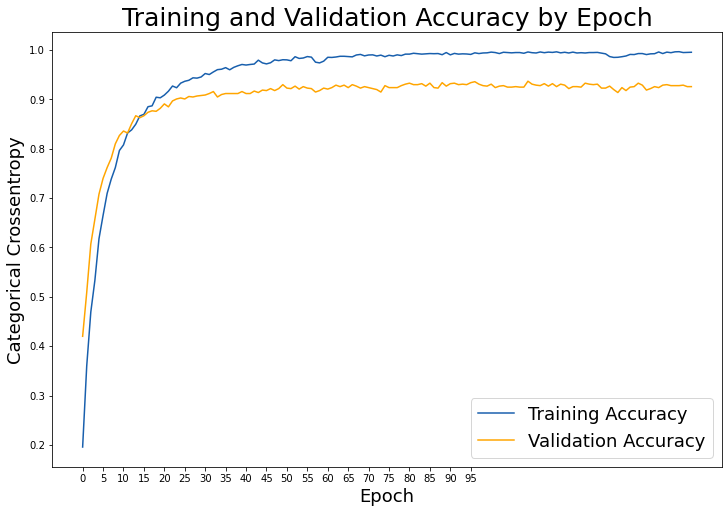

In [39]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt 

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [40]:
# Using our model to get the predictions for our test data
preds = model.predict_classes(X_test)

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:
# Looking at our test data as a dataframe to be able to compare prediction values
test = data[4435:]

In [42]:
# Setting our predictions column
test['preds'] = preds

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [43]:
# Changing the prediction values to their actual labels
test['preds'] = test['preds'].map({8:'siren', 9:'street_music', 7:'jackhammer',
                   4:'drilling', 3:'dog_bark', 2:'children_playing',
                   6:'gun_shot', 5:'engine_idling', 0:'air_conditioner',
                   1:'car_horn'})

In [44]:
# Looking at how accurate our model is just by looking at it
test

,ID,Class,preds
4435,7136,gun_shot,gun_shot
4436,7137,siren,siren
4437,7138,jackhammer,jackhammer
4438,7140,drilling,drilling
4439,7141,air_conditioner,air_conditioner
...,...,...,...
5430,8725,engine_idling,engine_idling
5431,8726,dog_bark,dog_bark
5432,8727,engine_idling,engine_idling
5433,8728,engine_idling,engine_idling


In [45]:
# Slicing our dataframe into the files we got wrong from our predictions
test[test['Class']!=test['preds']]

,ID,Class,preds
4461,7174,street_music,drilling
4465,7178,drilling,gun_shot
4468,7185,children_playing,siren
4473,7195,children_playing,street_music
4477,7200,dog_bark,children_playing
...,...,...,...
5407,8694,street_music,drilling
5416,8709,dog_bark,car_horn
5418,8711,dog_bark,children_playing
5420,8713,dog_bark,children_playing


In [46]:
# Calculating the actual test accuracy
round((1-len(test[test['Class']!=test['preds']])/len(test)),2)

0.92

### We got 93% accuracy in our test data

Saving the model to use in our voting classifier 

In [47]:
predic_nn = model.predict_proba(X_test)
predic_nn = pd.DataFrame(predic_nn)
predic_nn.to_csv('predict_nn.csv', index=False)

/Users/gildardo/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
